#### Imports

In [ ]:
%%capture
!pip install anndata
!pip install tensorflow
!pip install scikit-learn
!pip install sklearn
!pip install seaborn

!Rscript -e 'install.packages("plotly", repos="https://cloud.r-project.org")'
!Rscript -e 'install.packages("igraph", repos="https://cloud.r-project.org")'
!Rscript -e 'install.packages("cowplot", repos="https://cloud.r-project.org")'

import logging
import argparse
import warnings
warnings.filterwarnings("ignore")

import os
import time
import anndata

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm


def SVM(X_train, y_train):
    svm_classifier = svm.SVC(probability=True)
    cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

    y_pred_probs = cross_val_predict(svm_classifier, X_train, y_train, cv=5, method='predict_proba')
    y_pred = cross_val_predict(svm_classifier, X_train, y_train, cv=5)
    
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(svm_classifier, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return svm_classifier, fpr, tpr, roc_auc, mean_score, std_score

def RF(X_train, y_train):

    # Create RandomForestClassifier instance
    rf_classifier = RandomForestClassifier()

    # Perform 5-fold cross-validation and compute mean accuracy
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()  # Calculate the standard deviation of the scores

    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

    y_pred_probs = cross_val_predict(rf_classifier, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(rf_classifier, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(rf_classifier, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return rf_classifier, fpr, tpr, roc_auc,mean_score, std_score


def logistic_regression(X_train, y_train):
   
    # Create logistic regression model instance
    logistic_reg = LogisticRegression()
    
    # Perform 5-fold cross-validation and compute mean accuracy
    cv_scores = cross_val_score(logistic_reg, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()
    std_accuracy = cv_scores.std()
    
    print("Mean Cross-Validated Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)
    
    y_pred_probs = cross_val_predict(logistic_reg, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    mean_score = cross_val_score(logistic_reg, X_train, y_train, scoring="roc_auc", cv = 5).mean()
    std_score = cross_val_score(logistic_reg, X_train, y_train, scoring="roc_auc", cv = 5).std()
    
    print("Mean AUC over folds:", mean_score)
    print("Standard Deviation of AUC:", std_score)
    
    # Plot ROC curve for the last fold (you can modify this if you want to visualize other folds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return logistic_reg, fpr, tpr, roc_auc, mean_score, std_score


def Classifier(Classifier, X_val,y_val, Model = "SVM"):
    X_test = X_val
    y_test = y_val   
    if Model == "SVM":
        y_pred = Classifier.predict(X_test)
        y_pred_proba = Classifier.decision_function(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", auc)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return

#### scVI Images

##### Prep Targets

In [7]:
df1 = pd.read_csv('scVI/40k_Sets/HPA_set1_Latent.csv', sep=',', index_col=0)
df2 = pd.read_csv('scVI/40k_Sets/HPA_set2_Latent.csv', sep=',', index_col=0)
df3 = pd.read_csv('scVI/40k_Sets/HPA_set3_Latent.csv', sep=',', index_col=0)
df4 = pd.read_csv('scVI/40k_Sets/HPA_set4_Latent.csv', sep=',', index_col=0)
df5 = pd.read_csv('scVI/40k_Sets/HPA_set5_Latent.csv', sep=',', index_col=0)
df6 = pd.read_csv('scVI/40k_Sets/HPA_set6_Latent.csv', sep=',', index_col=0)
df7 = pd.read_csv('scVI/40k_Sets/HPA_set7_Latent.csv', sep=',', index_col=0)
df8 = pd.read_csv('scVI/40k_Sets/HPA_set8_Latent.csv', sep=',', index_col=0)
df9 = pd.read_csv('scVI/40k_Sets/HPA_set9_Latent.csv', sep=',', index_col=0)
df10 = pd.read_csv('scVI/40k_Sets/HPA_set10_Latent.csv', sep=',', index_col=0)
df11 = pd.read_csv('scVI/40k_Sets/HPA_set11_Latent.csv', sep=',', index_col=0)
df12 = pd.read_csv('scVI/40k_Sets/HPA_set12_Latent.csv', sep=',', index_col=0)
df13 = pd.read_csv('scVI/40k_Sets/HPA_set13_Latent.csv', sep=',', index_col=0)
df14 = pd.read_csv('scVI/40k_Sets/HPA_set14_Latent.csv', sep=',', index_col=0)

HPA = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14], axis=1)

In [8]:
# Read Data
data_row = pd.read_csv('scVI/10k_Latent/Row_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
data_rank = pd.read_csv('scVI/10k_Latent/Rank_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)

####################

######################

data_log_200_10k = pd.read_csv('scVI/Log_Epoch/Log_10k_256L_128H_1D_200Epoch.csv', sep=',', index_col=0)
data_log_400_10k = pd.read_csv('scVI/Log_Epoch/Log_10k_256L_128H_1D_400Epoch.csv', sep=',', index_col=0)
data_log_600_10k = pd.read_csv('scVI/Log_Epoch/Log_10k_256L_128H_1D_600Epoch.csv', sep=',', index_col=0)
data_log_800_10k = pd.read_csv('scVI/Log_Epoch/Log_10k_256L_128H_1D_800Epoch.csv', sep=',', index_col=0)

data_log_200 = pd.read_csv('scVI/Log_Epoch_40k/HPA_set1_Latent200.csv', sep=',', index_col=0)
data_log_400 = pd.read_csv('scVI/Log_Epoch_40k/HPA_set1_Latent400.csv', sep=',', index_col=0)
data_log_600 = pd.read_csv('scVI/Log_Epoch_40k/HPA_set1_Latent.csv', sep=',', index_col=0)
data_log_800 = pd.read_csv('scVI/Log_Epoch_40k/HPA_set1_Latent800.csv', sep=',', index_col=0)

data_log_200.index = data_log.index
data_log_400.index = data_log.index
data_log_600.index = data_log.index
data_log_800.index = data_log.index

df1 = pd.read_csv('scVI/40k_Sets/HPA_set1_Latent.csv', sep=',', index_col=0)
df2 = pd.read_csv('scVI/40k_Sets/HPA_set2_Latent.csv', sep=',', index_col=0)
df3 = pd.read_csv('scVI/40k_Sets/HPA_set3_Latent.csv', sep=',', index_col=0)
df4 = pd.read_csv('scVI/40k_Sets/HPA_set4_Latent.csv', sep=',', index_col=0)
df5 = pd.read_csv('scVI/40k_Sets/HPA_set5_Latent.csv', sep=',', index_col=0)
df6 = pd.read_csv('scVI/40k_Sets/HPA_set6_Latent.csv', sep=',', index_col=0)
df7 = pd.read_csv('scVI/40k_Sets/HPA_set7_Latent.csv', sep=',', index_col=0)
df8 = pd.read_csv('scVI/40k_Sets/HPA_set8_Latent.csv', sep=',', index_col=0)
df9 = pd.read_csv('scVI/40k_Sets/HPA_set9_Latent.csv', sep=',', index_col=0)
df10 = pd.read_csv('scVI/40k_Sets/HPA_set10_Latent.csv', sep=',', index_col=0)
df11 = pd.read_csv('scVI/40k_Sets/HPA_set11_Latent.csv', sep=',', index_col=0)
df12 = pd.read_csv('scVI/40k_Sets/HPA_set12_Latent.csv', sep=',', index_col=0)
df13 = pd.read_csv('scVI/40k_Sets/HPA_set13_Latent.csv', sep=',', index_col=0)
df14 = pd.read_csv('scVI/40k_Sets/HPA_set14_Latent.csv', sep=',', index_col=0)

df1.index = data_log.index
df2.index = data_log.index
df3.index = data_log.index
df4.index = data_log.index
df5.index = data_log.index
df6.index = data_log.index
df7.index = data_log.index
df8.index = data_log.index
df9.index = data_log.index
df10.index = data_log.index
df11.index = data_log.index
df12.index = data_log.index
df13.index = data_log.index
df14.index = data_log.index

HPA.index = data_log.index

data_log_50k = pd.read_csv('scVI/50k_Latent/Log_50k_256L_128H_1D_600E.csv', sep=',', index_col=0)
data_log_10k = pd.read_csv('scVI/10k_Latent/Log_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
data_log_raw = pd.read_csv('data_log.csv', sep=',', index_col=0)
data_raw = pd.read_csv('data_raw.csv', sep=',', index_col=0)

data_log = pd.read_csv('scVI/10k_Latent/Log_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)

###########################
# TF Labels
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Red_TF["label"])

############################

Log_targets= data_log[data_log.index.isin(data_label["Gene"])].fillna(0)
Row_targets= data_row[data_row.index.isin(data_label["Gene"])].fillna(0)
Rank_targets= data_rank[data_rank.index.isin(data_label["Gene"])].fillna(0)

################################

Log_50k_targets = data_log_50k[data_log_50k.index.isin(data_label["Gene"])].fillna(0)
Log_raw = data_log_raw[data_log_raw.index.isin(data_label["Gene"])].fillna(0)
Raw_targets = data_raw[data_raw.index.isin(data_label["Gene"])].fillna(0)

###############################

Log_200Epoch= data_log_200[data_log_200.index.isin(data_label["Gene"])].fillna(0)
Log_400Epoch= data_log_400[data_log_400.index.isin(data_label["Gene"])].fillna(0)
Log_600Epoch= data_log_600[data_log_600.index.isin(data_label["Gene"])].fillna(0)
Log_800Epoch= data_log_800[data_log_800.index.isin(data_label["Gene"])].fillna(0)

###############################

Log_200Epoch_10k= data_log_200_10k[data_log_200_10k.index.isin(data_label["Gene"])].fillna(0)
Log_400Epoch_10k= data_log_400_10k[data_log_400_10k.index.isin(data_label["Gene"])].fillna(0)
Log_600Epoch_10k= data_log_600_10k[data_log_600_10k.index.isin(data_label["Gene"])].fillna(0)
Log_800Epoch_10k= data_log_800_10k[data_log_800_10k.index.isin(data_label["Gene"])].fillna(0)


###############################

df1 = df1[df1.index.isin(data_label["Gene"])].fillna(0)
df2 = df2[df2.index.isin(data_label["Gene"])].fillna(0)
df3 = df3[df3.index.isin(data_label["Gene"])].fillna(0)
df4 = df4[df4.index.isin(data_label["Gene"])].fillna(0)
df5 = df5[df5.index.isin(data_label["Gene"])].fillna(0)
df6 = df6[df6.index.isin(data_label["Gene"])].fillna(0)
df7 = df7[df7.index.isin(data_label["Gene"])].fillna(0)
df8 = df8[df8.index.isin(data_label["Gene"])].fillna(0)
df9 = df9[df9.index.isin(data_label["Gene"])].fillna(0)
df10 = df10[df10.index.isin(data_label["Gene"])].fillna(0)
df11 = df11[df11.index.isin(data_label["Gene"])].fillna(0)
df12 = df12[df12.index.isin(data_label["Gene"])].fillna(0)
df13 = df13[df13.index.isin(data_label["Gene"])].fillna(0)
df14 = df14[df14.index.isin(data_label["Gene"])].fillna(0)

###############################

HPA = HPA[HPA.index.isin(data_label["Gene"])].fillna(0)

##### SVM Test

In [4]:
data_log = pd.read_csv('data_log_50k.csv', sep=',', index_col=0)
data_log

,Brain,Adipose,Brain.1,Endometrium,Endometrium.1,Endometrium.2,Kidney,Skin,Brain.2,Skeletal,...,Adipose.7355,Prostate.3200,Skin.1357,Lymph.685,Endometrium.6203,Testis.619,Eye.1765,Ovary.3833,Brain.6698,Prostate.3201
Genes,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000000,4.0,0.0,0.000000,0.0,0.0,3.169925
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
ENSG00000000419,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.584963,0.0,0.0,1.584963,0.0,0.0,0.000000
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,1.584963
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
ENSG00000288678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
ENSG00000288681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [5]:
data_log = pd.read_csv('data_log_50k.csv', sep=',', index_col=0)
###########################
# TF Labels
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Red_TF["label"])

############################

Log_targets= data_log[data_log.index.isin(data_label["Gene"])].fillna(0)

Mean Cross-Validated Accuracy: 0.8194193141173993
Standard Deviation of Accuracy: 0.02942558109186297
Mean AUC over folds: 0.7308949771689498
Standard Deviation of AUC: 0.056487734232868285


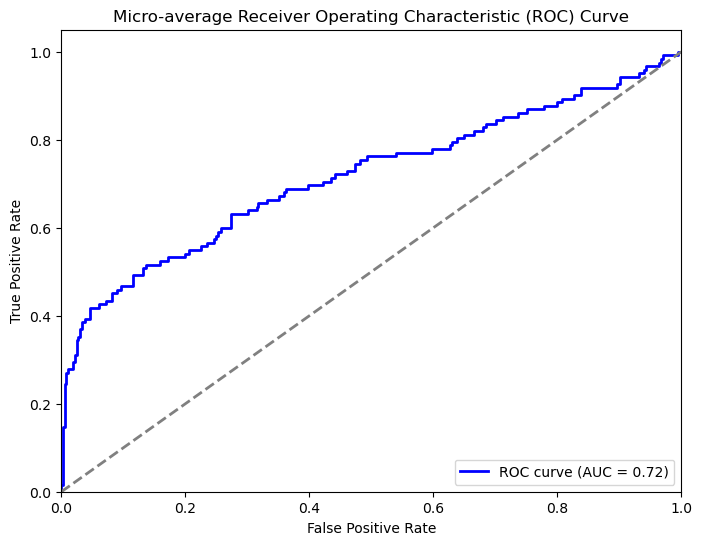

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
SVM_Classifier = SVM(Log_targets,labels["label"])

In [ ]:
import pickle

with open('data_log_50k.pkl', 'wb') as file:
    pickle.dump(SVM_Classifier, file)

In [12]:
import pickle

with open('HPA_set1_SVM_40k.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


##### SVM Image preparation

In [11]:
import pickle

with open('HPA_set1_SVM_40k.pkl', 'rb') as file:
    HPA_set1_SVM_40k = pickle.load(file)

In [9]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict

############

SVM_Classifier_Log = SVM(Log_targets,labels["label"])
SVM_Classifier_Row = SVM(Row_targets,labels["label"])
SVM_Classifier_Rank = SVM(Rank_targets,labels["label"])

#################

SVM_Classifier_Log_50k = SVM(Log_50k_targets,labels["label"])
SVM_Classifier_Log_Raw = SVM(Log_raw,labels["label"])
SVM_Classifier_Raw = SVM(Raw_targets,labels["label"])

#####################

SVM_Classifier_Log_200 = SVM(Log_200Epoch,labels["label"])
SVM_Classifier_Log_400 = SVM(Log_400Epoch,labels["label"])
SVM_Classifier_Log_600 = SVM(Log_600Epoch,labels["label"])
SVM_Classifier_Log_800 = SVM(Log_800Epoch,labels["label"])

#####################

SVM_Classifier_Log_200_10k = SVM(Log_200Epoch_10k,labels["label"])
SVM_Classifier_Log_400_10k = SVM(Log_400Epoch_10k,labels["label"])
SVM_Classifier_Log_600_10k = SVM(Log_600Epoch_10k,labels["label"])
SVM_Classifier_Log_800_10k = SVM(Log_800Epoch_10k,labels["label"])

#####################

SVM_Classifier_HPA_Set1 = SVM(df1,labels["label"])
SVM_Classifier_HPA_Set2 = SVM(df2,labels["label"])
SVM_Classifier_HPA_Set3 = SVM(df3,labels["label"])
SVM_Classifier_HPA_Set4 = SVM(df4,labels["label"])
SVM_Classifier_HPA_Set5 = SVM(df5,labels["label"])
SVM_Classifier_HPA_Set6 = SVM(df6,labels["label"])
SVM_Classifier_HPA_Set7 = SVM(df7,labels["label"])
SVM_Classifier_HPA_Set8 = SVM(df8,labels["label"])
SVM_Classifier_HPA_Set9 = SVM(df9,labels["label"])
SVM_Classifier_HPA_Set10 = SVM(df10,labels["label"])
SVM_Classifier_HPA_Set11 = SVM(df11,labels["label"])
SVM_Classifier_HPA_Set12 = SVM(df12,labels["label"])
SVM_Classifier_HPA_Set13 = SVM(df13,labels["label"])
SVM_Classifier_HPA_Set14 = SVM(df14,labels["label"])

#####################

SVM_HPA = SVM(HPA,labels["label"])

#######################

fpr1 = SVM_Classifier_Log[1]
tpr1 = SVM_Classifier_Log[2]
auc1 = SVM_Classifier_Log[3]
mean_acc1 = SVM_Classifier_Log[4]
std_acc1 = SVM_Classifier_Log[5]

fpr2 = SVM_Classifier_Row[1]
tpr2 = SVM_Classifier_Row[2]
auc2 = SVM_Classifier_Row[3]
mean_acc2 = SVM_Classifier_Row[4]
std_acc2 = SVM_Classifier_Row[5]

fpr3 = SVM_Classifier_Rank[1]
tpr3 = SVM_Classifier_Rank[2]
auc3 = SVM_Classifier_Rank[3]
mean_acc3 = SVM_Classifier_Rank[4]
std_acc3 = SVM_Classifier_Rank[5]

##############

fpr4 = SVM_Classifier_Log_50k[1]
tpr4 = SVM_Classifier_Log_50k[2]
auc4 = SVM_Classifier_Log_50k[3]
mean_acc4 = SVM_Classifier_Log_50k[4]
std_acc4 = SVM_Classifier_Log_50k[5]

fpr5 = SVM_Classifier_Log_Raw[1]
tpr5 = SVM_Classifier_Log_Raw[2]
auc5 = SVM_Classifier_Log_Raw[3]
mean_acc5 = SVM_Classifier_Log_Raw[4]
std_acc5 = SVM_Classifier_Log_Raw[5]

fpr6 = SVM_Classifier_Raw[1]
tpr6 = SVM_Classifier_Raw[2]
auc6 = SVM_Classifier_Raw[3]
mean_acc6 = SVM_Classifier_Raw[4]
std_acc6 = SVM_Classifier_Raw[5]

##################

fpr7 = SVM_Classifier_Log_200[1]
tpr7 = SVM_Classifier_Log_200[2]
auc7 = SVM_Classifier_Log_200[3]
mean_acc7 = SVM_Classifier_Log_200[4]
std_acc7 = SVM_Classifier_Log_200[5]

fpr8 = SVM_Classifier_Log_400[1]
tpr8 = SVM_Classifier_Log_400[2]
auc8 = SVM_Classifier_Log_400[3]
mean_acc8 = SVM_Classifier_Log_400[4]
std_acc8 = SVM_Classifier_Log_400[5]

fpr9 = SVM_Classifier_Log_600[1]
tpr9 = SVM_Classifier_Log_600[2]
auc9 = SVM_Classifier_Log_600[3]
mean_acc9 = SVM_Classifier_Log_600[4]
std_acc9 = SVM_Classifier_Log_600[5]

fpr10 = SVM_Classifier_Log_800[1]
tpr10 = SVM_Classifier_Log_800[2]
auc10 = SVM_Classifier_Log_800[3]
mean_acc10 = SVM_Classifier_Log_800[4]
std_acc10 = SVM_Classifier_Log_800[5]

#################################################
fpr11 = SVM_Classifier_HPA_Set1[1]
tpr11 = SVM_Classifier_HPA_Set1[2]
auc11 = SVM_Classifier_HPA_Set1[3]
mean_acc11 = SVM_Classifier_HPA_Set1[4]
std_acc11 = SVM_Classifier_HPA_Set1[5]

fpr12 = SVM_Classifier_HPA_Set2[1]
tpr12 = SVM_Classifier_HPA_Set2[2]
auc12 = SVM_Classifier_HPA_Set2[3]
mean_acc12 = SVM_Classifier_HPA_Set2[4]
std_acc12 = SVM_Classifier_HPA_Set2[5]

fpr13 = SVM_Classifier_HPA_Set3[1]
tpr13 = SVM_Classifier_HPA_Set3[2]
auc13 = SVM_Classifier_HPA_Set3[3]
mean_acc13 = SVM_Classifier_HPA_Set3[4]
std_acc13 = SVM_Classifier_HPA_Set3[5]

fpr14 = SVM_Classifier_HPA_Set4[1]
tpr14 = SVM_Classifier_HPA_Set4[2]
auc14 = SVM_Classifier_HPA_Set4[3]
mean_acc14 = SVM_Classifier_HPA_Set4[4]
std_acc14 = SVM_Classifier_HPA_Set4[5]

fpr15 = SVM_Classifier_HPA_Set5[1]
tpr15 = SVM_Classifier_HPA_Set5[2]
auc15 = SVM_Classifier_HPA_Set5[3]
mean_acc15 = SVM_Classifier_HPA_Set5[4]
std_acc15 = SVM_Classifier_HPA_Set5[5]

fpr16 = SVM_Classifier_HPA_Set6[1]
tpr16 = SVM_Classifier_HPA_Set6[2]
auc16 = SVM_Classifier_HPA_Set6[3]
mean_acc16 = SVM_Classifier_HPA_Set6[4]
std_acc16 = SVM_Classifier_HPA_Set6[5]

fpr17 = SVM_Classifier_HPA_Set7[1]
tpr17 = SVM_Classifier_HPA_Set7[2]
auc17 = SVM_Classifier_HPA_Set7[3]
mean_acc17 = SVM_Classifier_HPA_Set7[4]
std_acc17 = SVM_Classifier_HPA_Set7[5]

fpr18 = SVM_Classifier_HPA_Set8[1]
tpr18 = SVM_Classifier_HPA_Set8[2]
auc18 = SVM_Classifier_HPA_Set8[3]
mean_acc18 = SVM_Classifier_HPA_Set8[4]
std_acc18 = SVM_Classifier_HPA_Set8[5]

fpr19 = SVM_Classifier_HPA_Set9[1]
tpr19 = SVM_Classifier_HPA_Set9[2]
auc19 = SVM_Classifier_HPA_Set9[3]
mean_acc19 = SVM_Classifier_HPA_Set9[4]
std_acc19 = SVM_Classifier_HPA_Set9[5]

fpr20 = SVM_Classifier_HPA_Set10[1]
tpr20 = SVM_Classifier_HPA_Set10[2]
auc20 = SVM_Classifier_HPA_Set10[3]
mean_acc20 = SVM_Classifier_HPA_Set10[4]
std_acc20 = SVM_Classifier_HPA_Set10[5]

fpr21 = SVM_Classifier_HPA_Set11[1]
tpr21 = SVM_Classifier_HPA_Set11[2]
auc21 = SVM_Classifier_HPA_Set11[3]
mean_acc21 = SVM_Classifier_HPA_Set11[4]
std_acc21 = SVM_Classifier_HPA_Set11[5]

fpr22= SVM_Classifier_HPA_Set12[1]
tpr22 = SVM_Classifier_HPA_Set12[2]
auc22 = SVM_Classifier_HPA_Set12[3]
mean_acc22 = SVM_Classifier_HPA_Set12[4]
std_acc22= SVM_Classifier_HPA_Set12[5]

fpr23 = SVM_Classifier_HPA_Set13[1]
tpr23 = SVM_Classifier_HPA_Set13[2]
auc23 = SVM_Classifier_HPA_Set13[3]
mean_acc23 = SVM_Classifier_HPA_Set13[4]
std_acc23 = SVM_Classifier_HPA_Set13[5]

fpr24 = SVM_Classifier_HPA_Set14[1]
tpr24 = SVM_Classifier_HPA_Set14[2]
auc24 = SVM_Classifier_HPA_Set14[3]
mean_acc24 = SVM_Classifier_HPA_Set14[4]
std_acc24 = SVM_Classifier_HPA_Set14[5]

####################################################


fpr25 = HPA_set1_SVM_40k[1]
tpr25 = HPA_set1_SVM_40k[2]
auc25 = HPA_set1_SVM_40k[3]
mean_acc25 = HPA_set1_SVM_40k[4]
std_acc25 = HPA_set1_SVM_40k[5]

##################################################

fpr42 = SVM_HPA[1]
tpr42 = SVM_HPA[2]
auc42 = SVM_HPA[3]
mean_acc42 = SVM_HPA[4]
std_acc42 = SVM_HPA[5]



##################

fpr30 = SVM_Classifier_Log_200_10k[1]
tpr30 = SVM_Classifier_Log_200_10k[2]
auc30 = SVM_Classifier_Log_200_10k[3]
mean_acc30 = SVM_Classifier_Log_200_10k[4]
std_acc30 = SVM_Classifier_Log_200_10k[5]

fpr31 = SVM_Classifier_Log_400_10k[1]
tpr31 = SVM_Classifier_Log_400_10k[2]
auc31 = SVM_Classifier_Log_400_10k[3]
mean_acc31 = SVM_Classifier_Log_400_10k[4]
std_acc31 = SVM_Classifier_Log_400_10k[5]

fpr32 = SVM_Classifier_Log_600_10k[1]
tpr32 = SVM_Classifier_Log_600_10k[2]
auc32 = SVM_Classifier_Log_600_10k[3]
mean_acc32 = SVM_Classifier_Log_600_10k[4]
std_acc32 = SVM_Classifier_Log_600_10k[5]

fpr33 = SVM_Classifier_Log_800_10k[1]
tpr33 = SVM_Classifier_Log_800_10k[2]
auc33 = SVM_Classifier_Log_800_10k[3]
mean_acc33 = SVM_Classifier_Log_800_10k[4]
std_acc33 = SVM_Classifier_Log_800_10k[5]

NameError: name 'HPA_set1_SVM_40k' is not defined

In [10]:
import pickle

# Saving SVM_Classifier_Log_50k
with open('SVM_Classifier_Log_50k.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_50k, f)

# Saving SVM_Classifier_Log_Raw
with open('SVM_Classifier_Log_Raw.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_Raw, f)

# Saving SVM_Classifier_Raw
with open('SVM_Classifier_Raw.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Raw, f)

# Saving SVM_Classifier_Log_200
with open('SVM_Classifier_Log_200.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_200, f)

# Saving SVM_Classifier_Log_400
with open('SVM_Classifier_Log_400.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_400, f)

# Saving SVM_Classifier_Log_600
with open('SVM_Classifier_Log_600.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_600, f)

# Saving SVM_Classifier_Log_800
with open('SVM_Classifier_Log_800.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_800, f)

# Saving SVM_Classifier_Log_200_10k
with open('SVM_Classifier_Log_200_10k.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_200_10k, f)

# Saving SVM_Classifier_Log_400_10k
with open('SVM_Classifier_Log_400_10k.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_400_10k, f)

# Saving SVM_Classifier_Log_600_10k
with open('SVM_Classifier_Log_600_10k.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_600_10k, f)

# Saving SVM_Classifier_Log_800_10k
with open('SVM_Classifier_Log_800_10k.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log_800_10k, f)

# Saving SVM_Classifier_HPA_Set1
with open('SVM_Classifier_HPA_Set1.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set1, f)

# Saving SVM classifiers for Set 2
with open('SVM_Classifier_HPA_Set2.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set2, f)

# Saving SVM classifiers for Set 3
with open('SVM_Classifier_HPA_Set3.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set3, f)

# Saving SVM classifiers for Set 4
with open('SVM_Classifier_HPA_Set4.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set4, f)

# Saving SVM classifiers for Set 5
with open('SVM_Classifier_HPA_Set5.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set5, f)

# Saving SVM classifiers for Set 6
with open('SVM_Classifier_HPA_Set6.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set6, f)

# Saving SVM classifiers for Set 7
with open('SVM_Classifier_HPA_Set7.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set7, f)

# Saving SVM classifiers for Set 8
with open('SVM_Classifier_HPA_Set8.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set8, f)

# Saving SVM classifiers for Set 9
with open('SVM_Classifier_HPA_Set9.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set9, f)

# Saving SVM classifiers for Set 10
with open('SVM_Classifier_HPA_Set10.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set10, f)

# Saving SVM classifiers for Set 11
with open('SVM_Classifier_HPA_Set11.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set11, f)

# Saving SVM classifiers for Set 12
with open('SVM_Classifier_HPA_Set12.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set12, f)

# Saving SVM classifiers for Set 13
with open('SVM_Classifier_HPA_Set13.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set13, f)

# Saving SVM classifiers for Set 14
with open('SVM_Classifier_HPA_Set14.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_HPA_Set14, f)


# Saving SVM_HPA
with open('SVM_HPA.pkl', 'wb') as f:
    pickle.dump(SVM_HPA, f)


##### Images

###### Classifier Assessment

In [3]:
data_log = pd.read_csv('data_log.csv', sep=',', index_col=0)
data_row = pd.read_csv('data_row.csv', sep=',', index_col=0)
data_rank = pd.read_csv('data_rank.csv', sep=',', index_col=0)
Raw = pd.read_csv('data_raw.csv', sep=',', index_col=0)

dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Log_Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Log_Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Log_Red_TF["label"])

In [4]:
Raw_targets = Raw[Raw.index.isin(data_label["Gene"])].fillna(0)
Log_targets= data_log[data_log.index.isin(data_label["Gene"])].fillna(0)
Row_targets= data_row[data_row.index.isin(data_label["Gene"])].fillna(0)
Rank_targets= data_rank[data_rank.index.isin(data_label["Gene"])].fillna(0)

In [5]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict

Random_Forest_Log = RF(Log_targets,labels["label"])
Random_Forest_Row = RF(Row_targets,labels["label"])
Random_Forest_Rank = RF(Rank_targets,labels["label"])
Random_Forest_RawCounts = RF(Raw_targets,labels["label"])

SVM_Classifier_Log = SVM(Log_targets,labels["label"])
SVM_Classifier_Row = SVM(Row_targets,labels["label"])
SVM_Classifier_Rank = SVM(Rank_targets,labels["label"])
SVM_Classifier_RawCounts = SVM(Raw_targets,labels["label"])

Logistic_Regression_Log = logistic_regression(Log_targets,labels["label"])
Logistic_Regression_Row = logistic_regression(Row_targets,labels["label"])
Logistic_Regression_Rank = logistic_regression(Rank_targets,labels["label"])
Logistic_Regression_RawCounts = logistic_regression(Raw_targets,labels["label"])

In [6]:
import pickle

# Assuming you have already defined the variables

# Save Random Forest models
with open('Random_Forest_Log.pkl', 'wb') as f:
    pickle.dump(Random_Forest_Log, f)

with open('Random_Forest_Row.pkl', 'wb') as f:
    pickle.dump(Random_Forest_Row, f)

with open('Random_Forest_Rank.pkl', 'wb') as f:
    pickle.dump(Random_Forest_Rank, f)

with open('Random_Forest_RawCounts.pkl', 'wb') as f:
    pickle.dump(Random_Forest_RawCounts, f)

# Save SVM classifiers
with open('SVM_Classifier_Log.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Log, f)

with open('SVM_Classifier_Row.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Row, f)

with open('SVM_Classifier_Rank.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_Rank, f)

with open('SVM_Classifier_RawCounts.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier_RawCounts, f)

# Save Logistic Regression models
with open('Logistic_Regression_Log.pkl', 'wb') as f:
    pickle.dump(Logistic_Regression_Log, f)

with open('Logistic_Regression_Row.pkl', 'wb') as f:
    pickle.dump(Logistic_Regression_Row, f)

with open('Logistic_Regression_Rank.pkl', 'wb') as f:
    pickle.dump(Logistic_Regression_Rank, f)

with open('Logistic_Regression_RawCounts.pkl', 'wb') as f:
    pickle.dump(Logistic_Regression_RawCounts, f)


NameError: name 'legend' is not defined

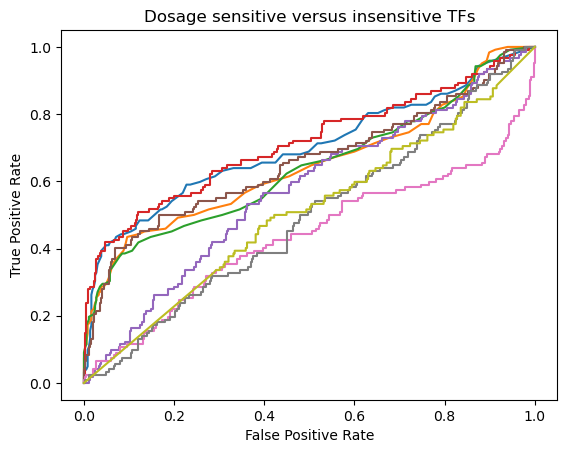

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Example data for three classifiers
fpr1 = Random_Forest_Log[1]
tpr1 = Random_Forest_Log[2]
auc1 = Random_Forest_Log[3]
mean_acc1 = Random_Forest_Log[4]
std_acc1 = Random_Forest_Log[5]

fpr2 = Random_Forest_Row[1]
tpr2 = Random_Forest_Row[2]
auc2 = Random_Forest_Row[3]
mean_acc2 = Random_Forest_Row[4]
std_acc2 = Random_Forest_Row[5]

fpr3 = Random_Forest_Rank[1]
tpr3 = Random_Forest_Rank[2]
auc3 = Random_Forest_Rank[3]
mean_acc3 = Random_Forest_Rank[4]
std_acc3 = Random_Forest_Rank[5]

fpr4 = SVM_Classifier_Log[1]
tpr4 = SVM_Classifier_Log[2]
auc4 = SVM_Classifier_Log[3]
mean_acc4 = SVM_Classifier_Log[4]
std_acc4 = SVM_Classifier_Log[5]

fpr5 = SVM_Classifier_Row[1]
tpr5 = SVM_Classifier_Row[2]
auc5 = SVM_Classifier_Row[3]
mean_acc5 = SVM_Classifier_Row[4]
std_acc5 = SVM_Classifier_Row[5]

fpr6 = SVM_Classifier_Rank[1]
tpr6 = SVM_Classifier_Rank[2]
auc6 = SVM_Classifier_Rank[3]
mean_acc6 = SVM_Classifier_Rank[4]
std_acc6 = SVM_Classifier_Rank[5]

fpr7 = Logistic_Regression_Log[1]
tpr7 = Logistic_Regression_Log[2]
auc7 = Logistic_Regression_Log[3]
mean_acc7 = Logistic_Regression_Log[4]
std_acc7 = Logistic_Regression_Log[5]

fpr8 = Logistic_Regression_Row[1]
tpr8 = Logistic_Regression_Row[2]
auc8 = Logistic_Regression_Row[3]
mean_acc8 = Logistic_Regression_Row[4]
std_acc8 = Logistic_Regression_Row[5]

fpr9 = Logistic_Regression_Rank[1]
tpr9 = Logistic_Regression_Rank[2]
auc9 = Logistic_Regression_Rank[3]
mean_acc9 = Logistic_Regression_Rank[4]
std_acc9 = Logistic_Regression_Rank[5]

# Example data for RawCounts classifiers
#fpr10 = Random_Forest_RawCounts[1]
#tpr10 = Random_Forest_RawCounts[2]
#auc10 = Random_Forest_RawCounts[3]
#mean_acc10 = Random_Forest_RawCounts[4]
#std_acc10 = Random_Forest_RawCounts[5]

#fpr11 = SVM_Classifier_RawCounts[1]
#tpr11 = SVM_Classifier_RawCounts[2]
#auc11 = SVM_Classifier_RawCounts[3]
#mean_acc11 = SVM_Classifier_RawCounts[4]
#std_acc11 = SVM_Classifier_RawCounts[5]

#fpr12 = Logistic_Regression_RawCounts[1]
#tpr12 = Logistic_Regression_RawCounts[2]
#auc12 = Logistic_Regression_RawCounts[3]
#mean_acc12 = Logistic_Regression_RawCounts[4]
#std_acc12 = Logistic_Regression_RawCounts[5]

# Create a new figure and plot the ROC curves
plt.figure()

plt.plot(fpr1, tpr1, label='RF Log (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1))
plt.plot(fpr2, tpr2, label='RF Row (5FCV = %0.2f ± %0.2f)' % (mean_acc2, std_acc2))
plt.plot(fpr3, tpr3, label='RF Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc3, std_acc3))
plt.plot(fpr4, tpr4, label='SVM Log (5FCV = %0.2f ± %0.2f)' % (mean_acc4, std_acc4))
plt.plot(fpr5, tpr5, label='SVM Row (5FCV = %0.2f ± %0.2f)' % (mean_acc5, std_acc5))
plt.plot(fpr6, tpr6, label='SVM Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc6, std_acc6))
plt.plot(fpr7, tpr7, label='LR Log (5FCV = %0.2f ± %0.2f)' % (mean_acc7, std_acc7))
plt.plot(fpr8, tpr8, label='LR Row (5FCV = %0.2f ± %0.2f)' % (mean_acc8, std_acc8))
plt.plot(fpr9, tpr9, label='LR Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc9, std_acc9))
#plt.plot(fpr10, tpr10, label='RF RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc10, std_acc10))
#plt.plot(fpr11, tpr11, label='SVM RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc11, std_acc11))
#plt.plot(fpr12, tpr12, label='LR RawCounts (5FCV = %0.2f ± %0.2f)' % (mean_acc12, std_acc12))

# Set plot title and labels
plt.title('Dosage sensitive versus insensitive TFs')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add legend on the right side with a title
legend3 = legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend3.get_title(), fontsize='small')
axs[1, 1].set_title('Dosage sensitive versus insensitive TFs')

                    # Set the title font size
plt.setp(legend.get_title(), fontsize='large')

# Save the plot to a file
plt.savefig('roc_plot.png')

# Show the plot
plt.show()

###### scVI Dim reduction assessment

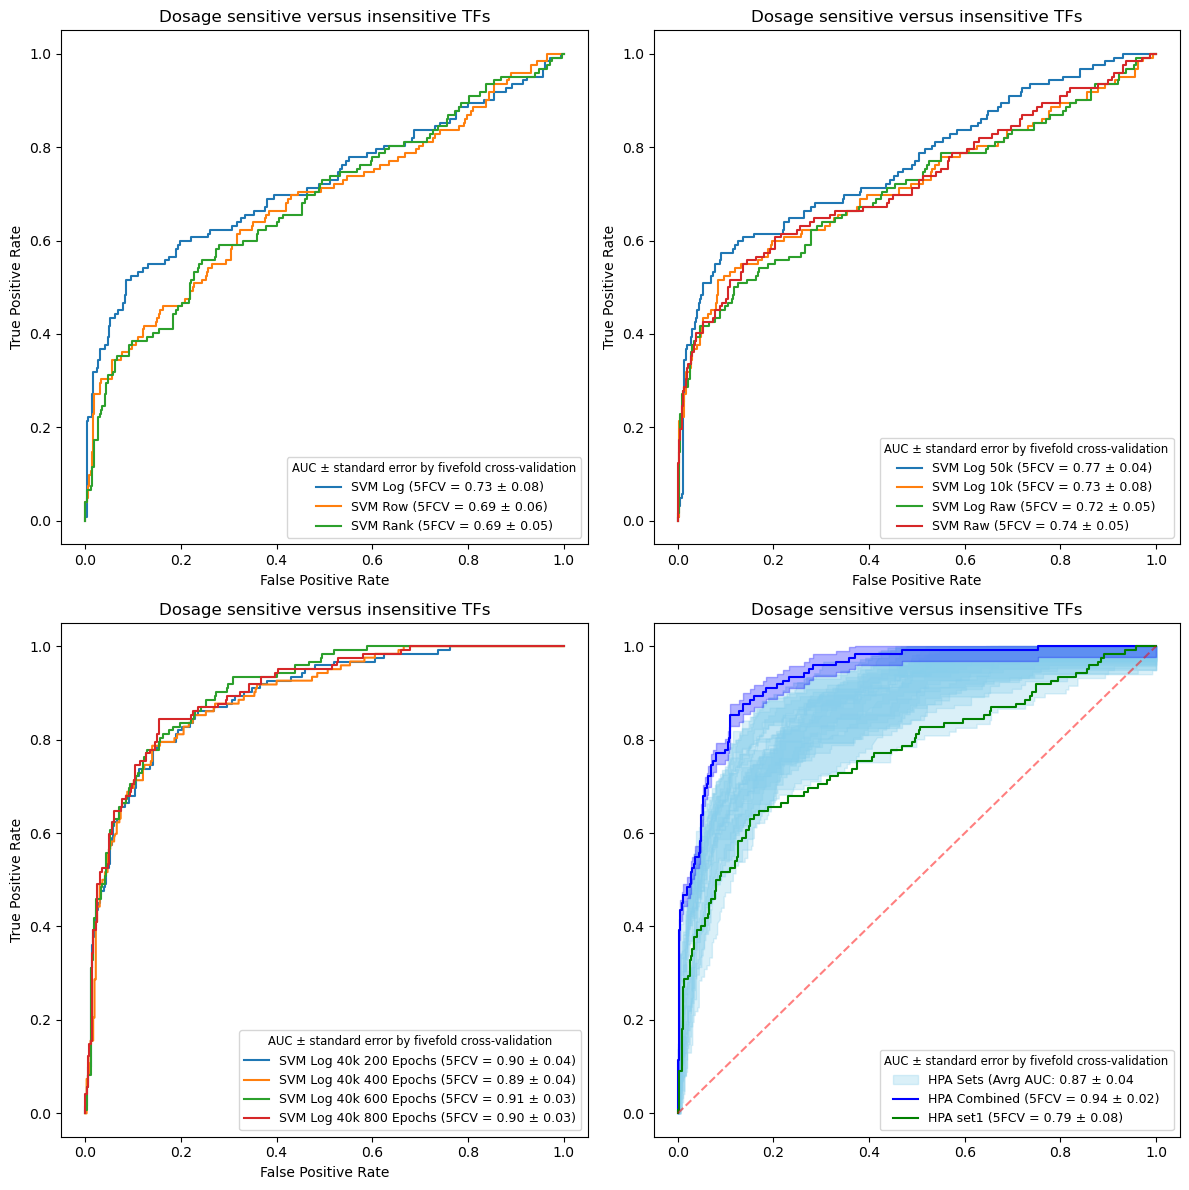

In [14]:
import matplotlib.pyplot as plt

# Create a new figure and plot the ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create a 2x2 subplot grid

######################################

# Plot for the first image (top left)
axs[0, 0].plot(fpr1, tpr1, label='SVM Log (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1))
axs[0, 0].plot(fpr2, tpr2, label='SVM Row (5FCV = %0.2f ± %0.2f)' % (mean_acc2, std_acc2))
axs[0, 0].plot(fpr3, tpr3, label='SVM Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc3, std_acc3))
axs[0, 0].set_title('Dosage sensitive versus insensitive TFs')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
legend1 = axs[0, 0].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend1.get_title(), fontsize='small')

##########################################

# Plot for the second image (top right)
axs[0, 1].plot(fpr4, tpr4, label='SVM Log 50k (5FCV = %0.2f ± %0.2f)' % (mean_acc4, std_acc4))
axs[0, 1].plot(fpr1, tpr1, label='SVM Log 10k (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1))
axs[0, 1].plot(fpr5, tpr5, label='SVM Log Raw (5FCV = %0.2f ± %0.2f)' % (mean_acc5, std_acc5))
axs[0, 1].plot(fpr6, tpr6, label='SVM Raw (5FCV = %0.2f ± %0.2f)' % (mean_acc6, std_acc6))
axs[0, 1].set_title('Dosage sensitive versus insensitive TFs')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
legend2 = axs[0, 1].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend2.get_title(), fontsize='small')

#################################################

upper_bound11 = np.minimum(tpr11 + std_acc11, 1.0)
lower_bound11 = np.maximum(tpr11 - std_acc11, 0.0)

upper_bound12 = np.minimum(tpr12 + std_acc12, 1.0)
lower_bound12 = np.maximum(tpr12 - std_acc12, 0.0)

upper_bound13 = np.minimum(tpr13 + std_acc13, 1.0)
lower_bound13 = np.maximum(tpr13 - std_acc13, 0.0)

upper_bound14 = np.minimum(tpr14 + std_acc14, 1.0)
lower_bound14 = np.maximum(tpr14 - std_acc14, 0.0)

upper_bound15 = np.minimum(tpr15 + std_acc15, 1.0)
lower_bound15 = np.maximum(tpr15 - std_acc15, 0.0)

upper_bound16 = np.minimum(tpr16 + std_acc16, 1.0)
lower_bound16 = np.maximum(tpr16 - std_acc16, 0.0)

upper_bound17 = np.minimum(tpr17 + std_acc17, 1.0)
lower_bound17 = np.maximum(tpr17 - std_acc17, 0.0)

upper_bound18 = np.minimum(tpr18 + std_acc18, 1.0)
lower_bound18 = np.maximum(tpr18 - std_acc18, 0.0)

upper_bound19 = np.minimum(tpr19 + std_acc19, 1.0)
lower_bound19 = np.maximum(tpr19 - std_acc19, 0.0)

upper_bound20 = np.minimum(tpr20 + std_acc20, 1.0)
lower_bound20 = np.maximum(tpr20 - std_acc20, 0.0)

upper_bound21 = np.minimum(tpr21 + std_acc21, 1.0)
lower_bound21 = np.maximum(tpr21 - std_acc21, 0.0)

upper_bound22 = np.minimum(tpr22 + std_acc22, 1.0)
lower_bound22 = np.maximum(tpr22 - std_acc22, 0.0)

upper_bound23 = np.minimum(tpr23 + std_acc23, 1.0)
lower_bound23 = np.maximum(tpr23 - std_acc23, 0.0)

upper_bound24 = np.minimum(tpr24 + std_acc24, 1.0)
lower_bound24 = np.maximum(tpr24 - std_acc24, 0.0)

mean_acc = [mean_acc11, mean_acc12, mean_acc13, mean_acc14, mean_acc15,
                   mean_acc16, mean_acc17, mean_acc18, mean_acc19, mean_acc20,
                   mean_acc21, mean_acc22, mean_acc23, mean_acc24]

std_acc = [std_acc11, std_acc12, std_acc13, std_acc14, std_acc15,
                  std_acc16, std_acc17, std_acc18, std_acc19, std_acc20,
                  std_acc21, std_acc22, std_acc23, std_acc24]

axs[1, 1].fill_between(fpr11, lower_bound11, upper_bound11, color='skyblue', alpha=0.3, label='HPA Sets (Avrg AUC: %0.2f ± %0.2f' % (np.mean(mean_acc), np.mean(std_acc)))
axs[1, 1].fill_between(fpr12, lower_bound12, upper_bound12, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr13, lower_bound13, upper_bound13, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr14, lower_bound14, upper_bound14, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr15, lower_bound15, upper_bound15, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr16, lower_bound16, upper_bound16, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr17, lower_bound17, upper_bound17, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr18, lower_bound18, upper_bound18, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr19, lower_bound19, upper_bound19, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr20, lower_bound20, upper_bound20, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr21, lower_bound21, upper_bound21, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr22, lower_bound22, upper_bound22, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr23, lower_bound23, upper_bound23, color='skyblue', alpha=0.3)
axs[1, 1].fill_between(fpr24, lower_bound24, upper_bound24, color='skyblue', alpha=0.3)

####
axs[1, 1].plot(fpr42, tpr42,color="blue", alpha=1, label='HPA Combined (5FCV = %0.2f ± %0.2f)' % (mean_acc42, std_acc42))

upper_bound42 = np.minimum(tpr42 + std_acc42, 1.0)
lower_bound42 = np.maximum(tpr42 - std_acc42, 0.0)

axs[1, 1].fill_between(fpr42, lower_bound42, upper_bound42, color="blue", alpha=0.3)

axs[1, 1].plot(fpr25, tpr25,color="green", alpha=1, label='HPA set1 (5FCV = %0.2f ± %0.2f)' % (mean_acc25, std_acc25))
#upper_bound25 = np.minimum(tpr25 + std_acc25, 1.0)
#lower_bound25 = np.maximum(tpr25 - std_acc25, 0.0)
#axs[1, 1].fill_between(fpr25, lower_bound25, upper_bound25, color="green", alpha=0.3)

####
axs[1, 1].plot([0, 1], [0, 1], color='red', linestyle='--',alpha=0.5 )  # Adding the diagonal red line

legend3 = axs[1, 1].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend3.get_title(), fontsize='small')
axs[1, 1].set_title('Dosage sensitive versus insensitive TFs')
#####################################################

# Plot for the third image (bottom left)
axs[1, 0].plot(fpr7, tpr7, label='SVM Log 40k 200 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc7, std_acc7))
axs[1, 0].plot(fpr8, tpr8, label='SVM Log 40k 400 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc8, std_acc8))
axs[1, 0].plot(fpr9, tpr9, label='SVM Log 40k 600 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc9, std_acc9))
axs[1, 0].plot(fpr10, tpr10, label='SVM Log 40k 800 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc10, std_acc10))

axs[1, 0].set_title('Dosage sensitive versus insensitive TFs')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
legend3 = axs[1, 0].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend3.get_title(), fontsize='small')

######################################################

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot to a file
plt.savefig('roc_plot_scVI.png')

# Show the plot
plt.show()



##### scVI Supplementary Figures

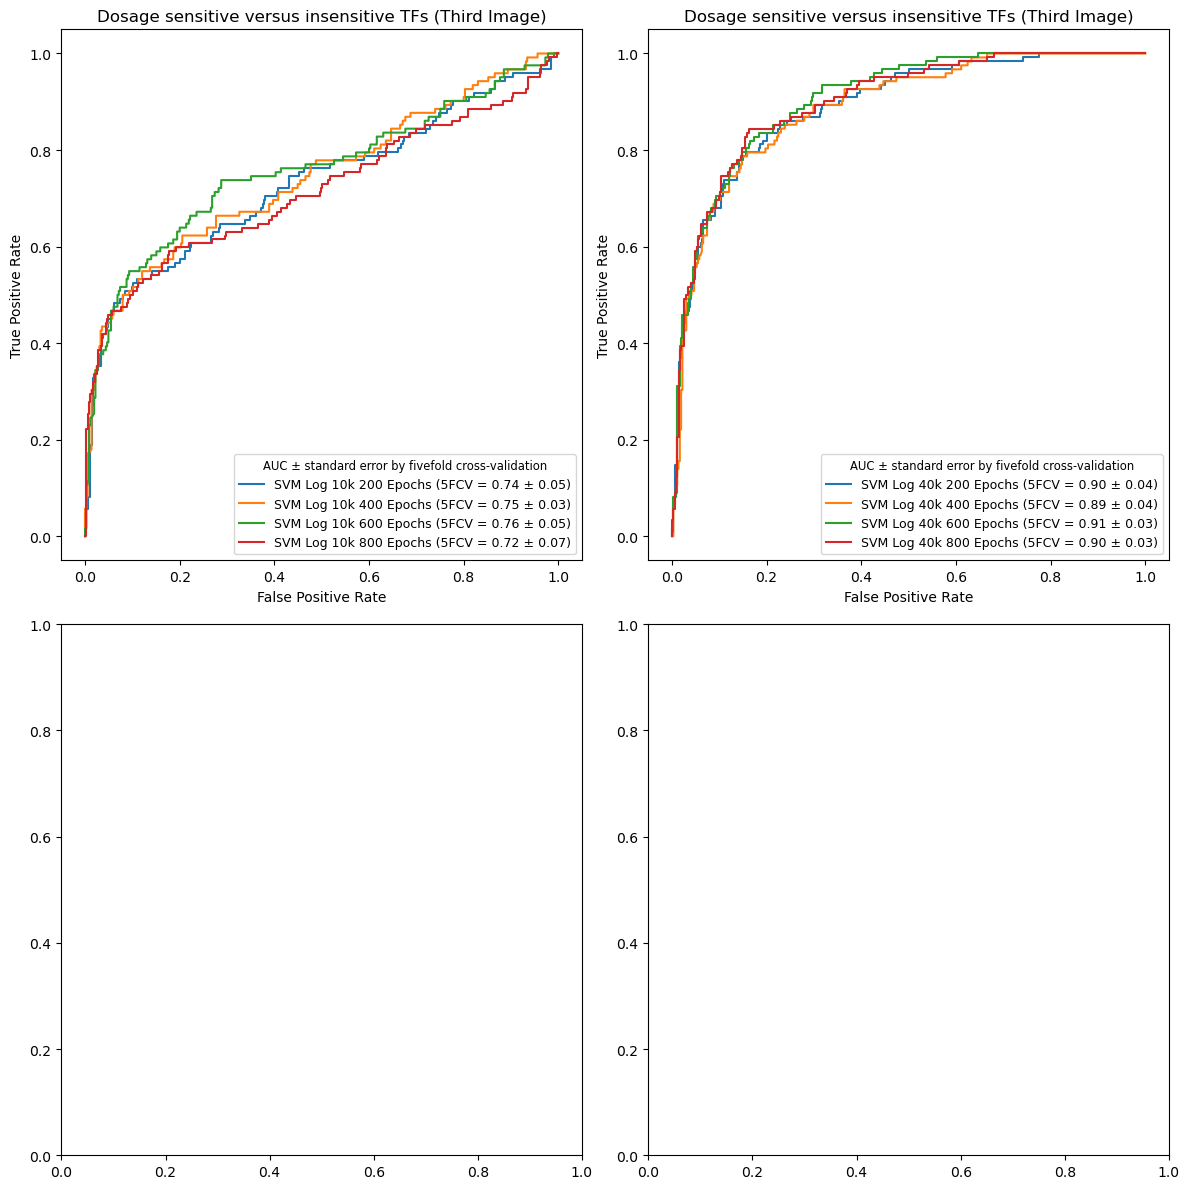

In [11]:
import matplotlib.pyplot as plt

# Create a new figure and plot the ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create a 2x2 subplot grid

#############################################
axs[0, 0].plot(fpr30, tpr30, label='SVM Log 10k 200 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc30, std_acc30))
axs[0, 0].plot(fpr31, tpr31, label='SVM Log 10k 400 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc31, std_acc31))
axs[0, 0].plot(fpr32, tpr32, label='SVM Log 10k 600 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc32, std_acc32))
axs[0, 0].plot(fpr33, tpr33, label='SVM Log 10k 800 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc33, std_acc33))

axs[0, 0].set_title('Dosage sensitive versus insensitive TFs (Third Image)')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
legend3 = axs[0, 0].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend3.get_title(), fontsize='small')


#############################################
# Plot for the third image (bottom left)
axs[0, 1].plot(fpr7, tpr7, label='SVM Log 40k 200 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc7, std_acc7))
axs[0, 1].plot(fpr8, tpr8, label='SVM Log 40k 400 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc8, std_acc8))
axs[0, 1].plot(fpr9, tpr9, label='SVM Log 40k 600 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc9, std_acc9))
axs[0, 1].plot(fpr10, tpr10, label='SVM Log 40k 800 Epochs (5FCV = %0.2f ± %0.2f)' % (mean_acc10, std_acc10))

axs[0, 1].set_title('Dosage sensitive versus insensitive TFs (Third Image)')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
legend3 = axs[0, 1].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend3.get_title(), fontsize='small')

######################################################

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot to a file
plt.savefig('scVI_Supplementary_Figure.png')

# Show the plot
plt.show()



#### CRISPR Images

##### PCA Images

In [4]:
%%capture
!pip install numpy scikit-learn
!pip install seaborn

Explained Variance Ratio:
PC1: 0.0739
PC2: 0.0425


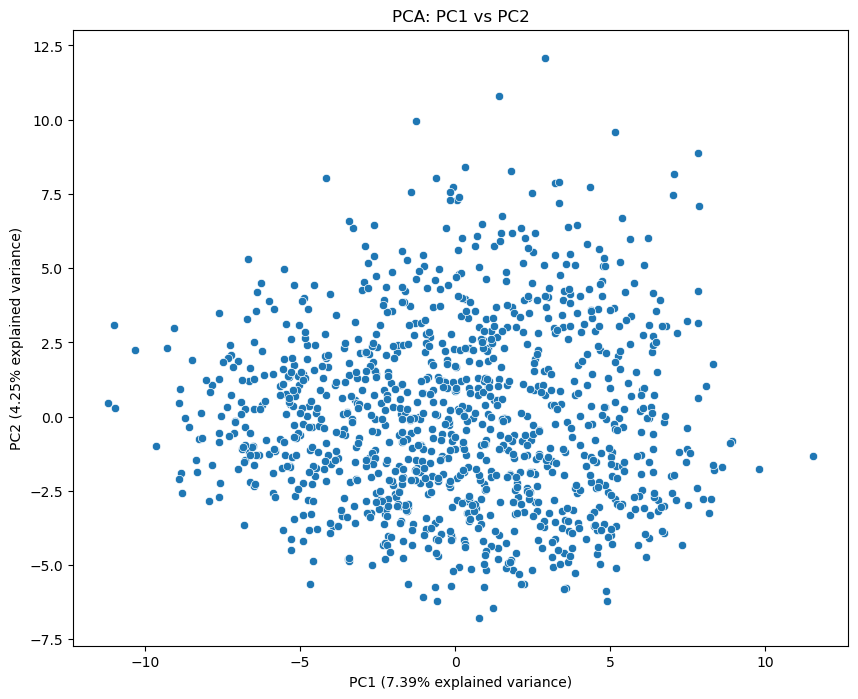

In [45]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('CRISPR_Image_Stuff//CRISPRGeneDependency_CorrelationMatrix.csv', sep='\t', index_col=0)
df = df.fillna(0)
df = df.transpose()

pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'



plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=pc1, y=pc2)
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
plt.title("PCA: PC1 vs PC2")

#plt.savefig('CRISPRLogMatrix_PCA.png')
plt.show()




Explained Variance Ratio:
PC1: 0.7582
PC2: 0.0324


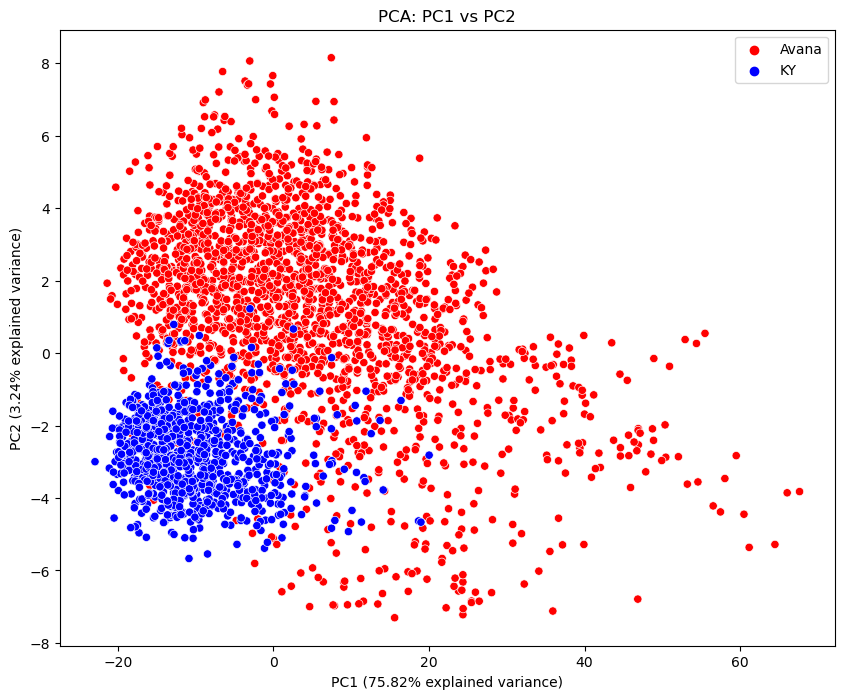

In [39]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('CRISPR_Image_Stuff//GeneL2FC_Avana_KY.tsv', sep='\t', index_col=0)
df = df.transpose()
# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'

df.iloc[:, :2077] = 'Avana'  # Update labels for the first 2077 columns
df.iloc[2077:, :] = 'KY'


plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=pc1, y=pc2, hue=df.iloc[:,0], palette={"Avana": "red", "KY": "blue"})
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
plt.title("PCA: PC1 vs PC2")

# Remove the legend title
legend = scatter.legend()
legend.set_title("")

plt.savefig('CRISPRLogMatrix_PCA.png')
plt.show()


Explained Variance Ratio:
PC1: 0.5135
PC2: 0.0381


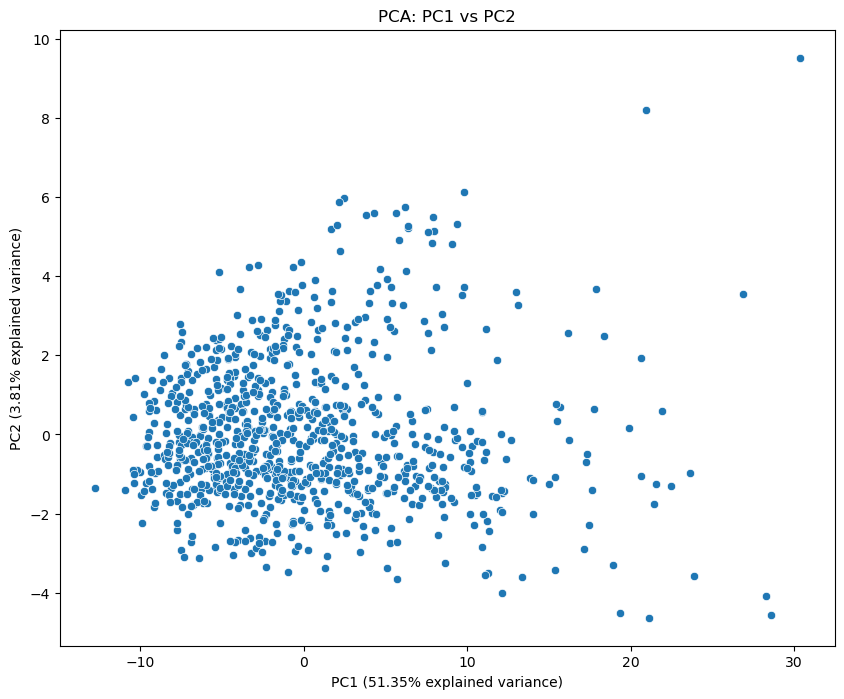

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

#df = pd.read_csv('CRISPR_Image_Stuff//AvanaLogFoldchange_CorrelationMatrix.txt', sep='\t', index_col=0)

df = pd.read_csv('CRISPR_Image_Stuff//KYLogFoldchange_CorrelationMatrix.txt', sep='\t', index_col=0)
df = df.fillna(0) 
mask = df.isna()

df = df.fillna(df.mean())

    
for col in df:
    Scaled = df[col].values
    
    
    Scaled -= Scaled.min()  # equivalent to df = df - df.min()
    Scaled /= Scaled.max()  

    # replace the original column with the scaled values
    df[col] = Scaled
    

df = df.mask(mask)
df = df.transpose()
# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'



plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=pc1, y=pc2)
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
plt.title("PCA: PC1 vs PC2")

#plt.savefig('CRISPRLogMatrix_PCA.png')
plt.show()



##### UMAP Images

In [ ]:
%%capture

!pip uninstall umap
!pip install umap-learn
!pip install umap-learn --upgrade

In [ ]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame called "df"
# with the data you want to perform UMAP on
df = pd.read_csv('Achilles_Matrices//CRISPRGeneDependency_CorrelationMatrix.csv', sep='\t', index_col=0)

# Extract the numerical values from the DataFrame
#data = df_imputed.values
data = df.dropna()

# Generate labels for coloration
df = data.transpose()
Model = pd.read_csv('Achilles//Model.csv', sep=',', index_col=0)
df_updated = df.copy()

for i in df.index:
    if i in Model.index:
        df_updated.index = df_updated.index.map(lambda x: Model.loc[i, "OncotreeLineage"] if x == i else x) # OncotreeLineage ; OncotreePrimaryDisease
    else:
        df_updated.index = df_updated.index.map(lambda x: "Unknown" if x == i else x)


# Select only the data with "Melanoma" as the value in "OncotreePrimaryDisease" column
data = df_updated[df_updated.index == 'Pancreas']
data = data.transpose()

# Perform UMAP
umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.05, metric='euclidean', n_components=2)

embedding = umap_obj.fit_transform(data)

In [ ]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame called "df"
# with the data you want to perform UMAP on
df = pd.read_csv('Achilles_Matrices//CRISPRGeneDependency_CorrelationMatrix.csv', sep='\t', index_col=0)

# Extract the numerical values from the DataFrame
#data = df_imputed.values
data = df.dropna()
#data = data.transpose()

# Perform UMAP
umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.05, metric='euclidean', n_components=2)

embedding = umap_obj.fit_transform(data)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the embedding
embedding_df = pd.DataFrame(embedding, columns=[f"UMAP Dimension {i+1}" for i in range(embedding.shape[1])])


# Visualize the embedding with labels using seaborn
sns.scatterplot(data=embedding_df, x="UMAP Dimension 1", y="UMAP Dimension 2")
plt.title('UMAP Visualization')
plt.show()

##### CRISPR Images

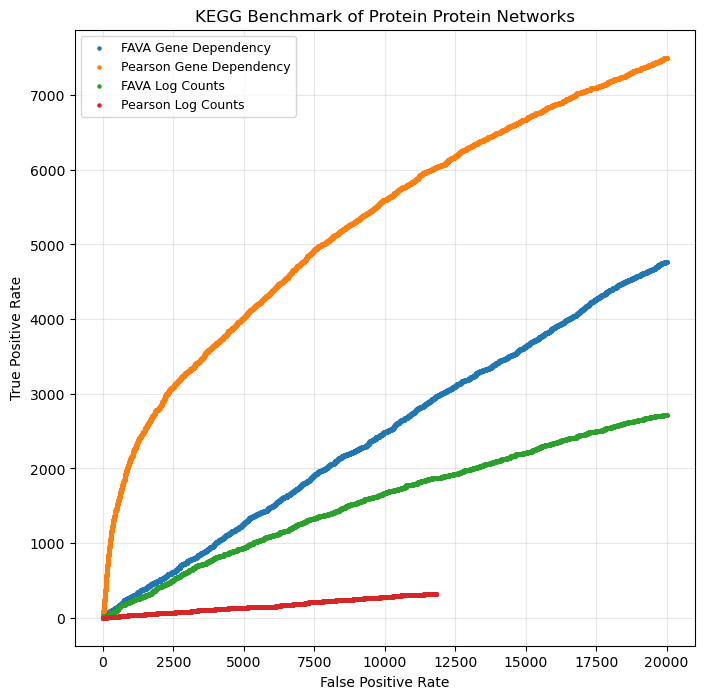

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

input_file = 'CRISPR_Image_Stuff/KEGG_Benchmarked_GeneDependency_1000H_100L_Network.tsv'
input_file2 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_GeneDependency_1000H_100L_Network.tsv'

input_file3 = 'CRISPR_Image_Stuff/KEGG_Benchmarked_GeneLog_1000H_100L_Network.tsv'
input_file4 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_GeneLog_1000H_100L_Network.tsv'

df11 = pd.read_csv(input_file, sep="\t")
df1 = df11[df11['fp_cum'] <= 20000]

df22 = pd.read_csv(input_file2, sep="\t")
df2 = df22[df22['fp_cum'] <= 20000]

df33 = pd.read_csv(input_file3, sep="\t")
df3 = df33[df33['fp_cum'] <= 20000]

df44 = pd.read_csv(input_file4, sep="\t")
df4 = df44[df44['fp_cum'] <= 20000]

# Create a scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figsize for a quadratic plot
plt.grid(True)  # Enable grid lines
plt.scatter(df1['fp_cum'], df1['tp_cum'], label='FAVA Gene Dependency',s=5, zorder=2)
plt.scatter(df2['fp_cum'], df2['tp_cum'], label='Pearson Gene Dependency',s=5, zorder=2)
plt.scatter(df3['fp_cum'], df3['tp_cum'], label='FAVA Log Counts',s=5, zorder=2)
plt.scatter(df4['fp_cum'], df4['tp_cum'], label='Pearson Log Counts',s=5, zorder=2)

# Adding legend and adjusting its properties
legend = plt.legend(loc='upper left', fontsize=9)
plt.setp(legend.get_title(), fontsize='small')

plt.title("KEGG Benchmark of Protein Protein Networks")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid(True, alpha=0.3)  # Enable grid lines
plt.show()


### Figure 1

#### Load Models and prep image inputs

In [5]:
Adipose = pd.read_csv("HPA_Cell_Types/Latent/Adipose_Latent.csv", sep=',', index_col=0)
Adipose

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.081211,-0.085951,-0.018658,-0.025801,0.108973,0.027884,0.050661,0.032636,-0.046722,-0.567965,...,0.040689,0.020405,-0.099910,0.076434,0.062923,-0.025664,-0.064391,-0.001563,0.055180,-0.533682
1,0.321173,0.002777,-0.001663,0.015279,0.025909,0.004982,-0.062225,-0.008904,-0.040067,-0.045933,...,0.017777,0.016129,-0.013424,-0.009555,0.020114,-0.017602,-0.013241,0.001563,-0.029592,-0.037785
2,0.401447,0.007358,0.024116,-0.031377,-0.006702,-0.002268,-0.122091,0.048472,-0.061230,0.561053,...,-0.003055,0.027509,0.043323,0.687042,-0.003246,-0.014688,-0.033612,0.007827,-0.032629,-0.615117
3,0.105252,-0.074559,0.037586,-0.059999,0.074886,0.033544,0.007637,0.152176,-0.047126,0.323917,...,0.050746,0.095502,-0.034116,0.156811,-0.091956,0.075628,-0.046956,-0.075192,-0.067531,0.268046
4,-0.605896,-0.057269,0.054784,-0.008530,0.006777,-0.012658,0.032258,0.000446,0.020792,0.002525,...,0.008662,-0.014385,0.024840,-0.309852,-0.065820,0.061294,0.029512,-0.018696,0.011150,-0.174383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20085,0.264850,-0.001900,0.016622,0.007704,0.022477,-0.012086,-0.014798,-0.007182,-0.022064,0.068412,...,0.013361,-0.002143,0.005487,-0.213555,0.000067,0.000966,0.001848,-0.009571,-0.023050,0.118940
20086,0.264850,-0.001900,0.016622,0.007704,0.022477,-0.012086,-0.014798,-0.007182,-0.022064,0.068412,...,0.013361,-0.002143,0.005487,-0.213555,0.000067,0.000966,0.001848,-0.009571,-0.023050,0.118940
20087,0.264850,-0.001900,0.016622,0.007704,0.022477,-0.012086,-0.014798,-0.007182,-0.022064,0.068412,...,0.013361,-0.002143,0.005487,-0.213555,0.000067,0.000966,0.001848,-0.009571,-0.023050,0.118940
20088,0.264850,-0.001900,0.016622,0.007704,0.022477,-0.012086,-0.014798,-0.007182,-0.022064,0.068412,...,0.013361,-0.002143,0.005487,-0.213555,0.000067,0.000966,0.001848,-0.009571,-0.023050,0.118940


In [ ]:
# Read Data
data_log = pd.read_csv('scVI/10k_Latent/Log_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
#data_row = pd.read_csv('scVI/10k_Latent/Row_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)
#data_rank = pd.read_csv('scVI/10k_Latent/Rank_10k_256L_128H_1D_200E.csv', sep=',', index_col=0)


data_log_40k_raw = pd.read_csv("data_log_40k.csv", sep=',', index_col=0)
####################
data_log_40k = pd.read_csv('scVI/Log_40k_Latent.csv', sep=',', index_col=0)
data_log_10k = pd.read_csv('scVI/Log_10k_Latent.csv', sep=',', index_col=0)
data_log_40k.index = data_log.index
data_log_10k.index = data_log.index
Adipose.index = data_log.index
# TF Labels
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Red_TF["label"])

############################

Log_targets= data_log[data_log.index.isin(data_label["Gene"])].fillna(0)
#Row_targets= data_row[data_row.index.isin(data_label["Gene"])].fillna(0)
#Rank_targets= data_rank[data_rank.index.isin(data_label["Gene"])].fillna(0)

################################

Log_40k_targets = data_log_40k[data_log_40k.index.isin(data_label["Gene"])].fillna(0)
Log_10k_targets = data_log_10k[data_log_10k.index.isin(data_label["Gene"])].fillna(0)

data_log_40k_raw_targets = data_log_40k_raw[data_log_40k_raw.index.isin(data_label["Gene"])].fillna(0)

Adipose = Adipose[Adipose.index.isin(data_label["Gene"])].fillna(0)


Mean Cross-Validated Accuracy: 0.8194193141173993
Standard Deviation of Accuracy: 0.02942558109186297
Mean AUC over folds: 0.727013698630137
Standard Deviation of AUC: 0.05732162349633902


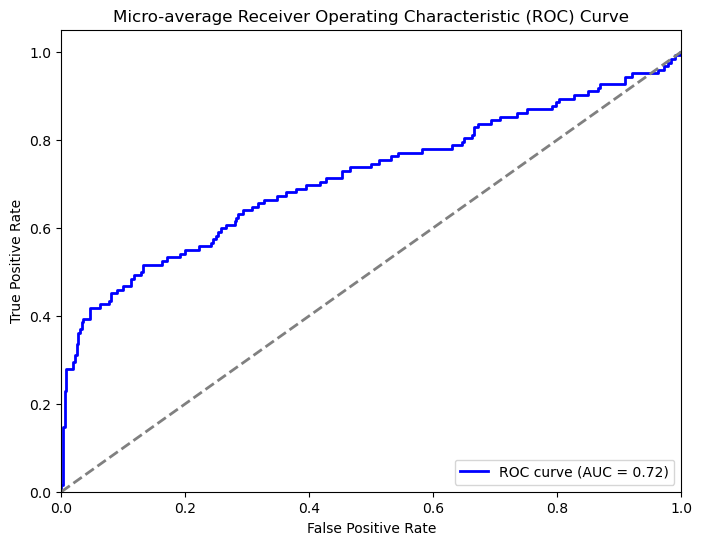

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
SVM_Classifier = SVM(Adipose,labels["label"])

In [5]:
import pickle
with open('SVM_Classifier_40k_Log_raw.pkl', 'wb') as f:
    pickle.dump(SVM_Classifier, f)

In [2]:
import pickle

# Load Random Forest models
with open('Random_Forest_Log.pkl', 'rb') as f:
    Random_Forest_Log = pickle.load(f)

with open('Random_Forest_Rank.pkl', 'rb') as f:
    Random_Forest_Rank = pickle.load(f)

with open('SVM_Classifier_Log.pkl', 'rb') as f:
    SVM_Classifier_Log = pickle.load(f)

with open('SVM_Classifier_Rank.pkl', 'rb') as f:
    SVM_Classifier_Rank = pickle.load(f)

# Load Logistic Regression models
with open('Logistic_Regression_Log.pkl', 'rb') as f:
    Logistic_Regression_Log = pickle.load(f)

with open('Logistic_Regression_Rank.pkl', 'rb') as f:
    Logistic_Regression_Rank = pickle.load(f)

# Load SVM_Classifier_Log_50k
with open('SVM_Classifier_Log_50k.pkl', 'rb') as f:
    SVM_Classifier_Log_50k = pickle.load(f)

with open('SVM_Classifier_40k_Log.pkl', 'rb') as f:
    SVM_Classifier_Log_40k = pickle.load(f)

with open('SVM_Classifier_10k_Log.pkl', 'rb') as f:
    SVM_Classifier_Log_10k = pickle.load(f)

with open('SVM_Classifier_40k_Log_raw.pkl', 'rb') as f:
    SVM_Classifier_Log_40k_raw = pickle.load(f)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Example data for three classifiers
fpr1 = Random_Forest_Log[1]
tpr1 = Random_Forest_Log[2]
auc1 = Random_Forest_Log[3]
mean_acc1 = Random_Forest_Log[4]
std_acc1 = Random_Forest_Log[5]

fpr3 = Random_Forest_Rank[1]
tpr3 = Random_Forest_Rank[2]
auc3 = Random_Forest_Rank[3]
mean_acc3 = Random_Forest_Rank[4]
std_acc3 = Random_Forest_Rank[5]

fpr4 = SVM_Classifier_Log[1]
tpr4 = SVM_Classifier_Log[2]
auc4 = SVM_Classifier_Log[3]
mean_acc4 = SVM_Classifier_Log[4]
std_acc4 = SVM_Classifier_Log[5]

fpr6 = SVM_Classifier_Rank[1]
tpr6 = SVM_Classifier_Rank[2]
auc6 = SVM_Classifier_Rank[3]
mean_acc6 = SVM_Classifier_Rank[4]
std_acc6 = SVM_Classifier_Rank[5]

fpr7 = Logistic_Regression_Log[1]
tpr7 = Logistic_Regression_Log[2]
auc7 = Logistic_Regression_Log[3]
mean_acc7 = Logistic_Regression_Log[4]
std_acc7 = Logistic_Regression_Log[5]

fpr9 = Logistic_Regression_Rank[1]
tpr9 = Logistic_Regression_Rank[2]
auc9 = Logistic_Regression_Rank[3]
mean_acc9 = Logistic_Regression_Rank[4]
std_acc9 = Logistic_Regression_Rank[5]

fpr10 = SVM_Classifier_Log_40k[1]
tpr10 = SVM_Classifier_Log_40k[2]
auc10 = SVM_Classifier_Log_40k[3]
mean_acc10 = SVM_Classifier_Log_40k[4]
std_acc10 = SVM_Classifier_Log_40k[5]

fpr11 = SVM_Classifier_Log_10k[1]
tpr11 = SVM_Classifier_Log_10k[2]
auc11 = SVM_Classifier_Log_10k[3]
mean_acc11 = SVM_Classifier_Log_10k[4]
std_acc11 = SVM_Classifier_Log_10k[5]

fpr12 = SVM_Classifier_Log_40k_raw[1]
tpr12 = SVM_Classifier_Log_40k_raw[2]
auc12 = SVM_Classifier_Log_40k_raw[3]
mean_acc12 = SVM_Classifier_Log_40k_raw[4]
std_acc12 = SVM_Classifier_Log_40k_raw[5]
# Continue this pattern for the remaining variables



#### Image 

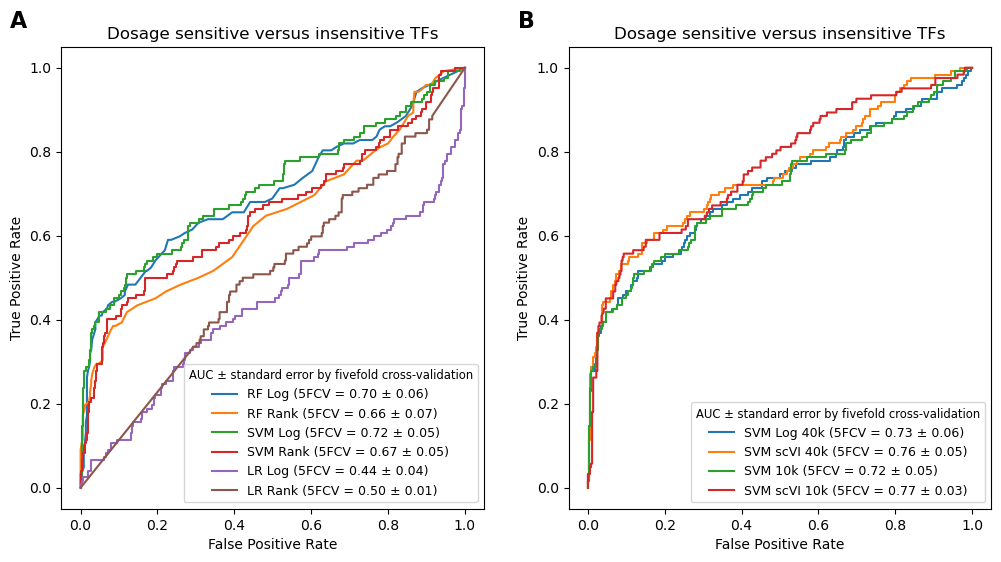

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 subplot grid


axs[0].plot(fpr1, tpr1, label='RF Log (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1))
axs[0].plot(fpr3, tpr3, label='RF Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc3, std_acc3))
axs[0].plot(fpr4, tpr4, label='SVM Log (5FCV = %0.2f ± %0.2f)' % (mean_acc4, std_acc4))
axs[0].plot(fpr6, tpr6, label='SVM Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc6, std_acc6))
axs[0].plot(fpr7, tpr7, label='LR Log (5FCV = %0.2f ± %0.2f)' % (mean_acc7, std_acc7))
axs[0].plot(fpr9, tpr9, label='LR Rank (5FCV = %0.2f ± %0.2f)' % (mean_acc9, std_acc9))

axs[0].set_title('Dosage sensitive versus insensitive TFs')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
legend1 = axs[0].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend1.get_title(), fontsize='small')

axs[1].plot(fpr12, tpr12, label='SVM Log 40k (5FCV = %0.2f ± %0.2f)' % (mean_acc12, std_acc12))
axs[1].plot(fpr10, tpr10, label='SVM scVI 40k (5FCV = %0.2f ± %0.2f)' % (mean_acc10, std_acc10))
axs[1].plot(fpr4, tpr4, label='SVM 10k (5FCV = %0.2f ± %0.2f)' % (mean_acc4, std_acc4))
axs[1].plot(fpr11, tpr11, label='SVM scVI 10k (5FCV = %0.2f ± %0.2f)' % (mean_acc11, std_acc11))

axs[1].set_title('Dosage sensitive versus insensitive TFs')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')

legend1 = axs[1].legend(loc='lower right', title='AUC ± standard error by fivefold cross-validation', fontsize=9)
plt.setp(legend1.get_title(), fontsize='small')
# Add labels to the top of the individual subplots
axs[0].text(-0.08, 1.08, 'A', transform=axs[0].transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].text(-0.08, 1.08, 'B', transform=axs[1].transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
plt.savefig('Figure_1.png')
plt.show()

### Figure 2

Adipose: 40.000
Bone: 3.230
Brain: 40.000
Breast: 40.000
Bronchus: 17520
Colon: 11167
Endometrium: 40.000
Esophagus:9117
Eye: 20090
Heart: 9182
Kidney: 25279
Liver: 8439
Lung: 4599
Lymph: 7771
Ovary: 40.000
Pancreas: 3719
PBMC: 4972
Placenta: 18547
Prostate: 35862
Rectum: 3898
Skeletal: 22030
Skin: 15798
Small: 6167
Spleen: 4512
Stomach: 5318
Testis: 6490

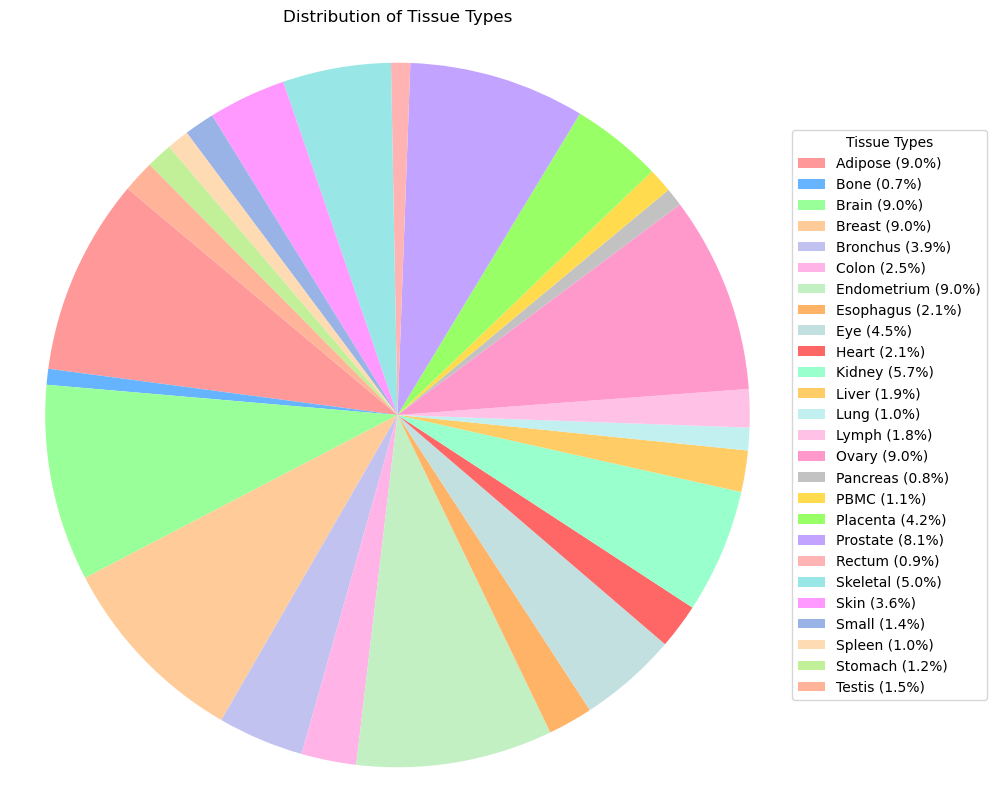

In [24]:
import matplotlib.pyplot as plt

# Data
labels = [
    'Adipose', 'Bone', 'Brain', 'Breast', 'Bronchus', 'Colon', 'Endometrium',
    'Esophagus', 'Eye', 'Heart', 'Kidney', 'Liver', 'Lung', 'Lymph', 'Ovary',
    'Pancreas', 'PBMC', 'Placenta', 'Prostate', 'Rectum', 'Skeletal', 'Skin',
    'Small', 'Spleen', 'Stomach', 'Testis'
]
sizes = [
    40000, 3230, 40000, 40000, 17520, 11167, 40000, 9117, 20090, 9182,
    25279, 8439, 4599, 7771, 40000, 3719, 4972, 18547, 35862, 3898, 22030, 15798,
    6167, 4512, 5318, 6490
]

# Define custom colors for the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2',
          '#ffb366', '#c2e0e0', '#ff6666', '#99ffcc', '#ffcc66', '#c2f0f0', '#ffc2e6',
          '#ff99cc', '#c2c2c2', '#ffdb4d', '#99ff66', '#c2a3ff', '#ffb3b3', '#99e6e6',
          '#ff99ff', '#99b3e6', '#ffdbb3', '#c2f099', '#ffb399', '#b3ffb3']

# Create a pie chart with custom colors and no labels
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=None, autopct='', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a legend with percentages
plt.legend(labels=[f'{label} ({size/sum(sizes)*100:.1f}%)' for label, size in zip(labels, sizes)],
           title="Tissue Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add a title
plt.title('Distribution of Tissue Types')

# Show the pie chart
plt.show()



In [2]:
import os
import pandas as pd

# Define the directory where your CSV files are located
directory = 'HPA_Cell_Types/Latent/'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Create an empty dictionary to store DataFrames
dataframes = {}

# Load the reference DataFrame (data_log) to determine the index
data_log = pd.read_csv('scVI/10k_Latent/Log_10k_256L_128H_1D_200E.csv', index_col=0)  # Adjust the path as needed

# Loop through the CSV files and load them into DataFrames
for csv_file in csv_files:
    # Extract the name of the DataFrame from the file name (without the .csv extension)
    dataframe_name = os.path.splitext(csv_file)[0]
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # Set the index of the DataFrame to match the index of data_log
    df.index = data_log.index
    
    # Store the DataFrame in the dictionary
    dataframes[dataframe_name] = df

# Now, you have a dictionary where keys are the DataFrame names, and each DataFrame has the same index as data_log
# You can access individual DataFrames like this:
# dataframes['DataFrameName']

# For example, to access the DataFrame with the name 'file1':
# df = dataframes['file1']
for dataframe_name, dataframe in dataframes.items():
    dataframes[dataframe_name] = dataframe.iloc[:, 1:]

In [3]:
###########################
# TF Labels
dosage_tfs = pd.read_csv("dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()

# Concatenate the sensitive and insensitive series into a new DataFrame
data_label = pd.concat([sensitive, insensitive], axis=0)

# Create the "label" column based on sensitivity
labels = [1] * len(sensitive) + [0] * len(insensitive)
data_label = pd.DataFrame({"Gene": data_label, "label": labels})

# Subset of df with matching row index and add label column
Red_TF = data_log[data_log.index.isin(data_label["Gene"])]
Red_TF["label"] = data_label.set_index("Gene")["label"]

# Create DataFrame with only the "label" column
labels = pd.DataFrame(Red_TF["label"])

# Create a dictionary to store Log_targets for each DataFrame
log_targets = {}

# Loop through the DataFrames in your 'dataframes' dictionary
for dataframe_name, dataframe in dataframes.items():
    # Create DataFrame with only the rows matching data_label and fill NaNs with 0
    log_targets[dataframe_name] = dataframe[dataframe.index.isin(data_label["Gene"])].fillna(0)


Mean Cross-Validated Accuracy: 0.755649063749211
Standard Deviation of Accuracy: 0.007484626345173185
Mean AUC over folds: 0.6540525114155251
Standard Deviation of AUC: 0.07905776370135648


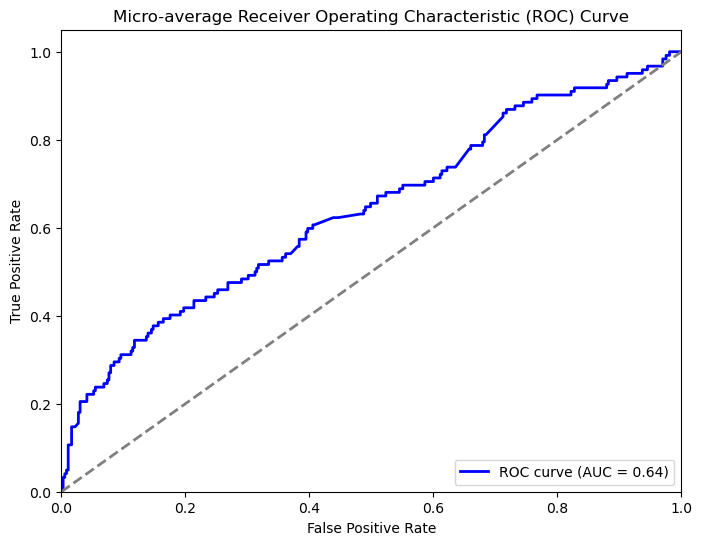

Mean Cross-Validated Accuracy: 0.8152745634336209
Standard Deviation of Accuracy: 0.04299239409911293
Mean AUC over folds: 0.8003972602739726
Standard Deviation of AUC: 0.06637663909942693


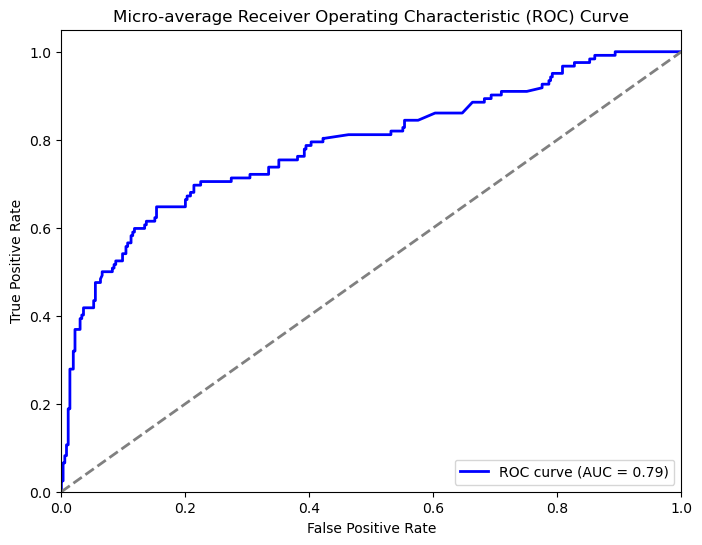

Mean Cross-Validated Accuracy: 0.8111087734062696
Standard Deviation of Accuracy: 0.017724644909341974
Mean AUC over folds: 0.8127511415525115
Standard Deviation of AUC: 0.035146867982447996


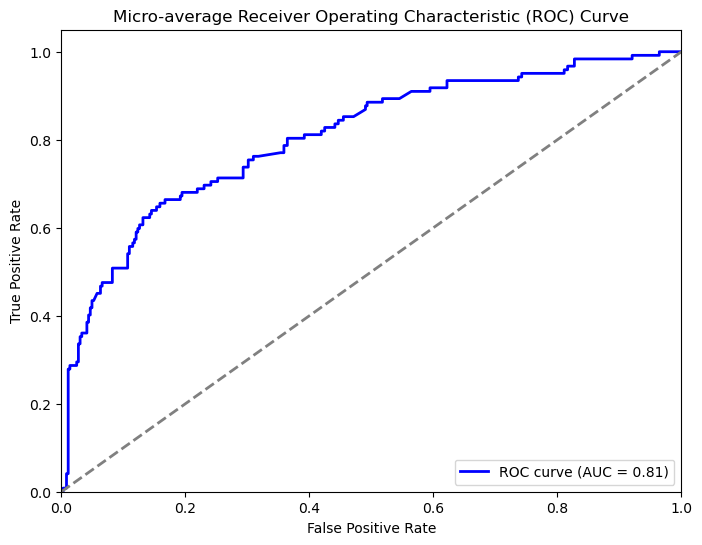

Mean Cross-Validated Accuracy: 0.8337260677466862
Standard Deviation of Accuracy: 0.017138427669999606
Mean AUC over folds: 0.7863150684931506
Standard Deviation of AUC: 0.0664699474547632


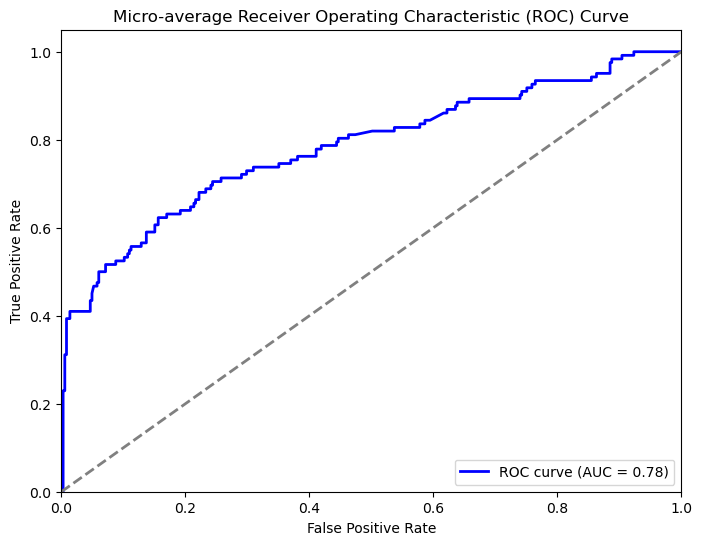

Mean Cross-Validated Accuracy: 0.8235640648011783
Standard Deviation of Accuracy: 0.04483831137495371
Mean AUC over folds: 0.8152694063926941
Standard Deviation of AUC: 0.05214338252223651


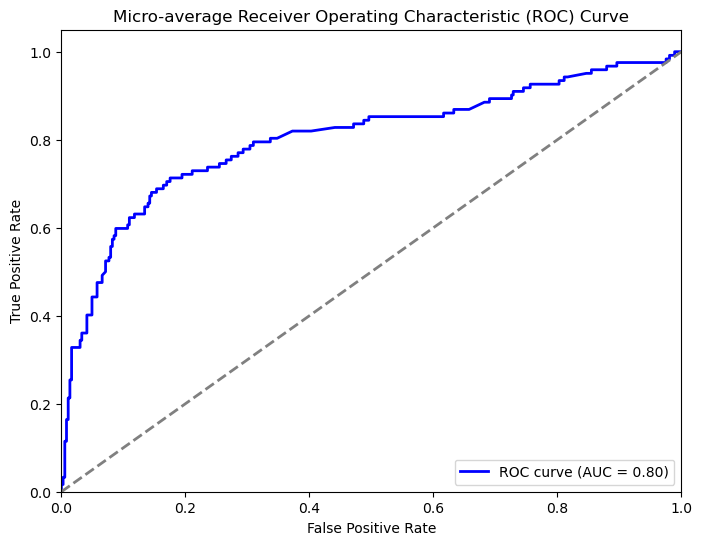

Mean Cross-Validated Accuracy: 0.8523038081211866
Standard Deviation of Accuracy: 0.03009023350989981
Mean AUC over folds: 0.8730662100456621
Standard Deviation of AUC: 0.04039320715277599


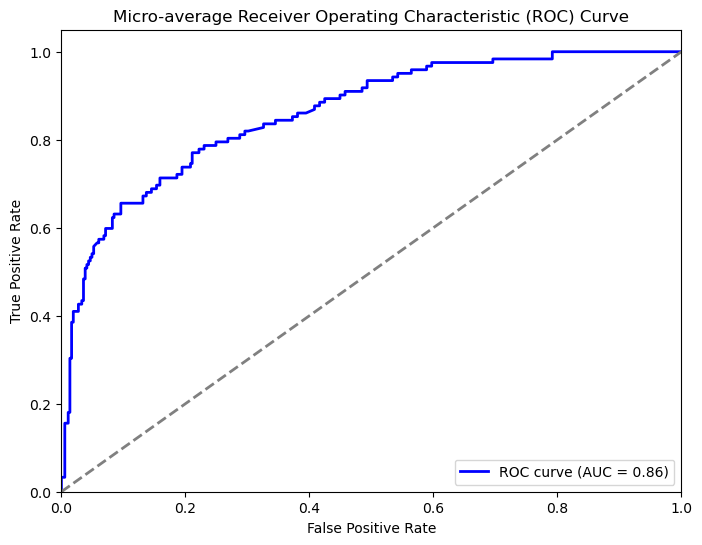

Mean Cross-Validated Accuracy: 0.8358300021039342
Standard Deviation of Accuracy: 0.03893924967807264
Mean AUC over folds: 0.8446712328767123
Standard Deviation of AUC: 0.05099325285467335


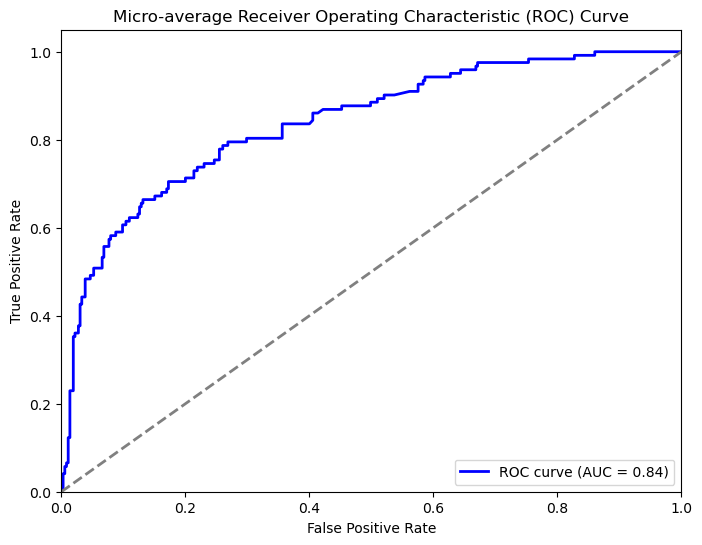

Mean Cross-Validated Accuracy: 0.7803071744161582
Standard Deviation of Accuracy: 0.014981667312049456
Mean AUC over folds: 0.7135388127853881
Standard Deviation of AUC: 0.06281799734332028


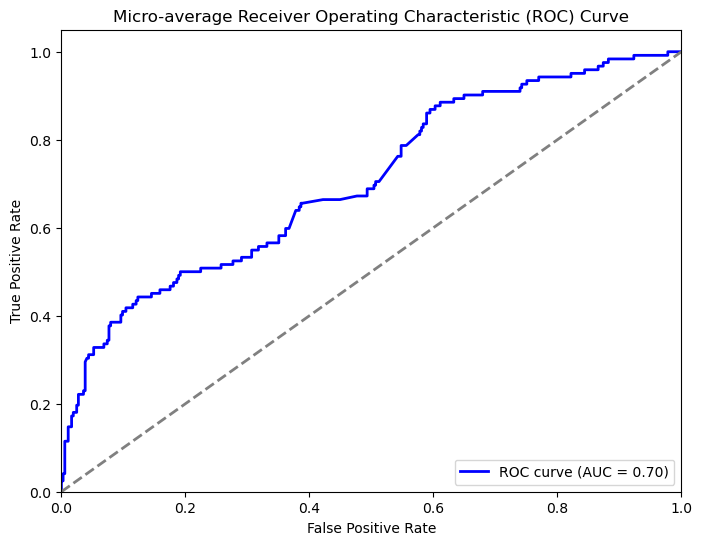

Mean Cross-Validated Accuracy: 0.7659162634125816
Standard Deviation of Accuracy: 0.011878270057174248
Mean AUC over folds: 0.7012602739726027
Standard Deviation of AUC: 0.07456967362987696


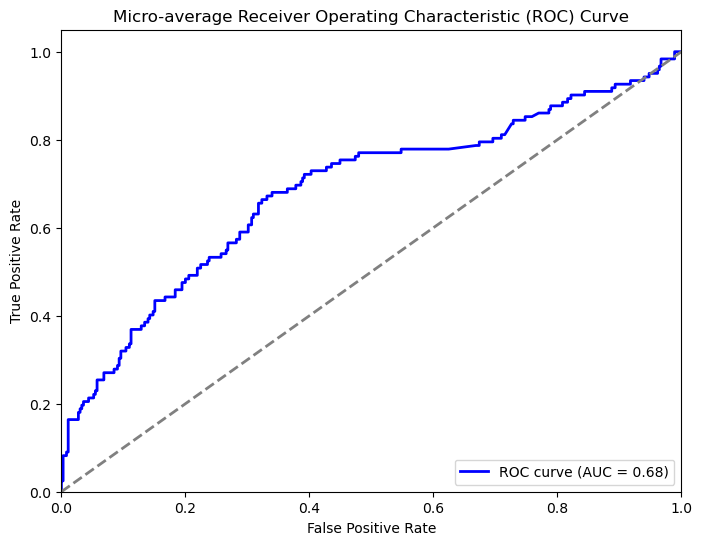

Mean Cross-Validated Accuracy: 0.8606143488323165
Standard Deviation of Accuracy: 0.05971008703668902
Mean AUC over folds: 0.9144794520547945
Standard Deviation of AUC: 0.0293523227343063


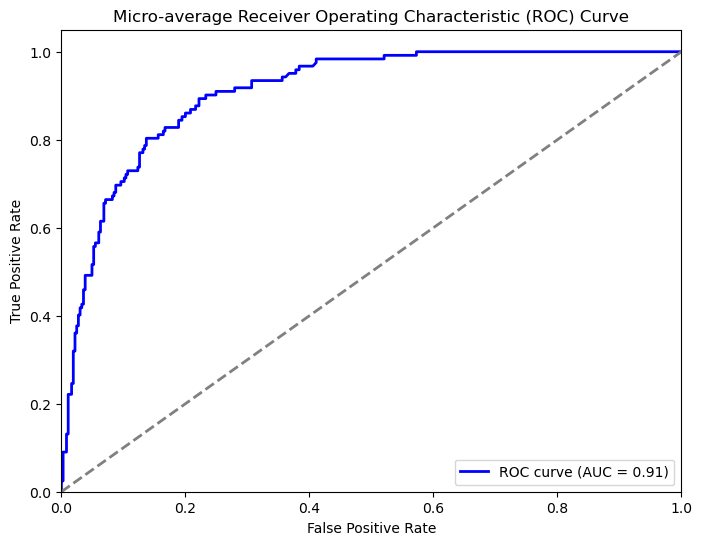

Mean Cross-Validated Accuracy: 0.7987376393856511
Standard Deviation of Accuracy: 0.014366867925866427
Mean AUC over folds: 0.844796803652968
Standard Deviation of AUC: 0.06449931157361057


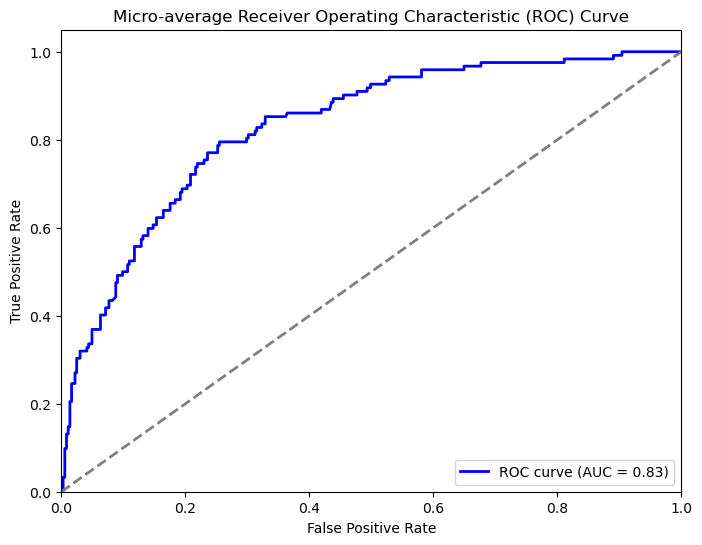

Mean Cross-Validated Accuracy: 0.8152324847464758
Standard Deviation of Accuracy: 0.015365434637818797
Mean AUC over folds: 0.8205639269406394
Standard Deviation of AUC: 0.029684623509080906


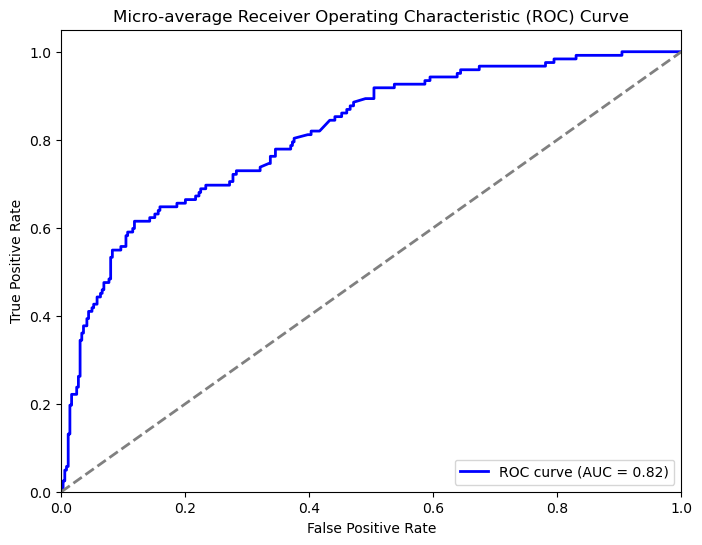

Mean Cross-Validated Accuracy: 0.8440563854407742
Standard Deviation of Accuracy: 0.03692207585321015
Mean AUC over folds: 0.855351598173516
Standard Deviation of AUC: 0.056641397123124215


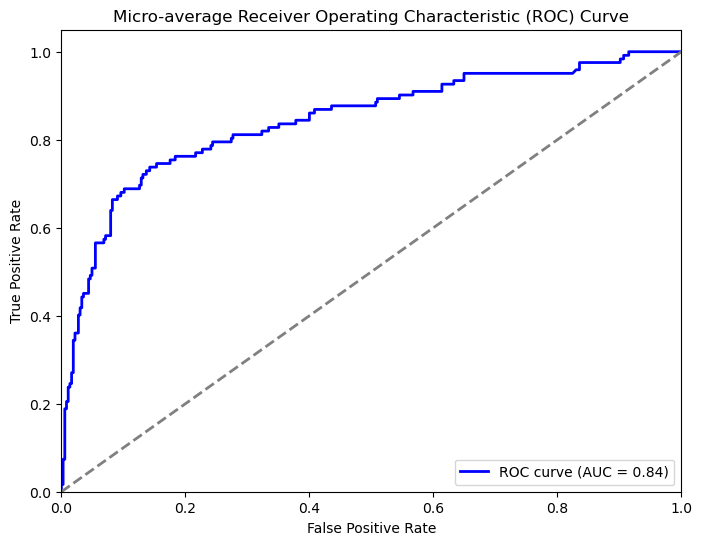

Mean Cross-Validated Accuracy: 0.8502419524510835
Standard Deviation of Accuracy: 0.02868200425013986
Mean AUC over folds: 0.8965753424657533
Standard Deviation of AUC: 0.030338399183259764


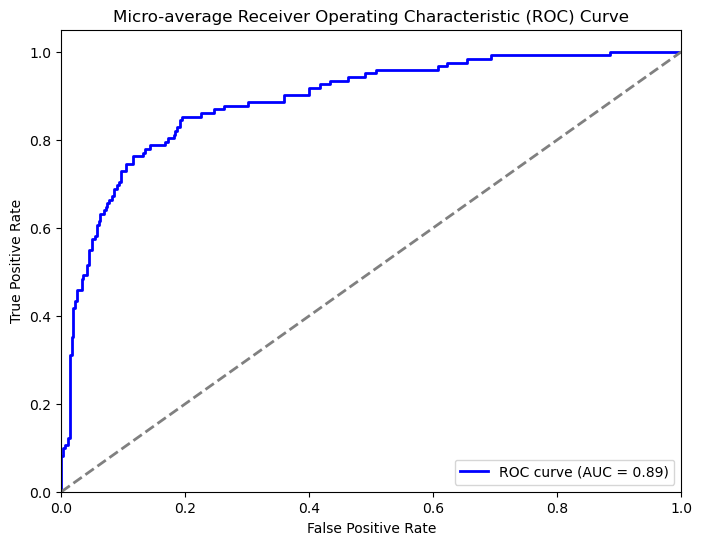

Mean Cross-Validated Accuracy: 0.8398695560698506
Standard Deviation of Accuracy: 0.029206549700113524
Mean AUC over folds: 0.8917625570776255
Standard Deviation of AUC: 0.02665907113319723


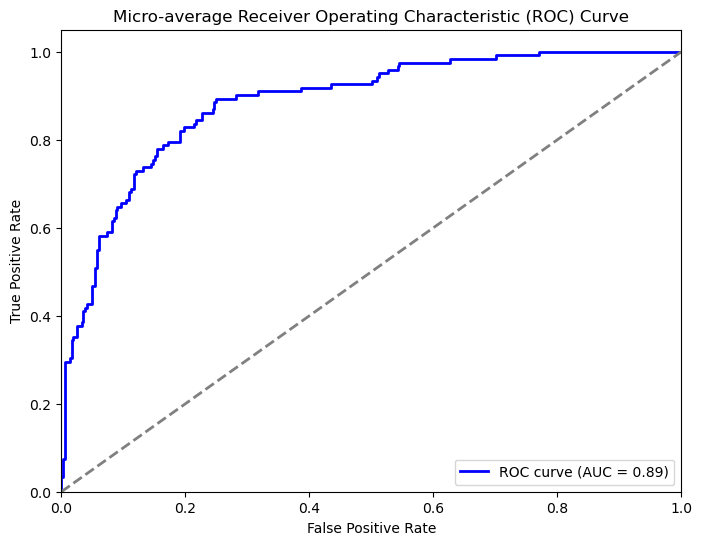

Mean Cross-Validated Accuracy: 0.8378918577740375
Standard Deviation of Accuracy: 0.04214858490804162
Mean AUC over folds: 0.8120525114155251
Standard Deviation of AUC: 0.07609906614172392


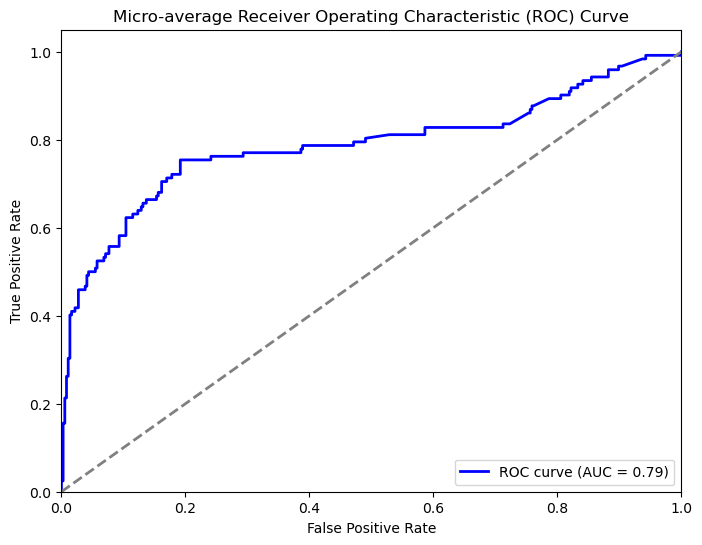

Mean Cross-Validated Accuracy: 0.8255417630969915
Standard Deviation of Accuracy: 0.02544261294903721
Mean AUC over folds: 0.858027397260274
Standard Deviation of AUC: 0.020420679450120223


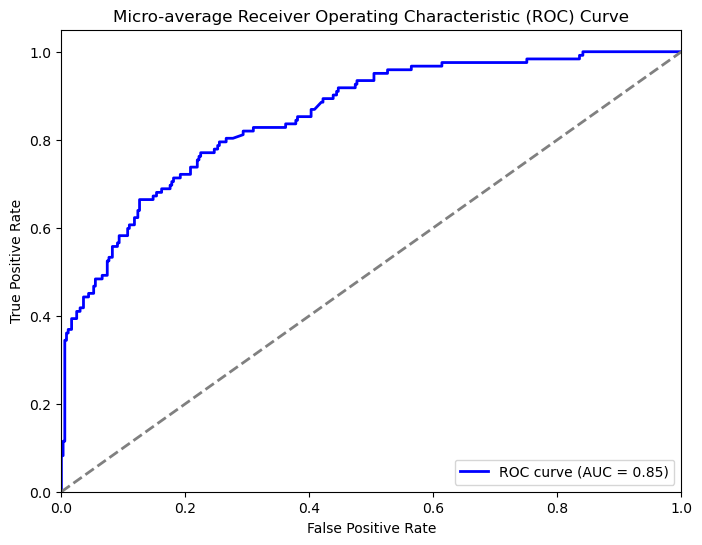

Mean Cross-Validated Accuracy: 0.7845150431306542
Standard Deviation of Accuracy: 0.03022245864828407
Mean AUC over folds: 0.7369155251141553
Standard Deviation of AUC: 0.06725066208014525


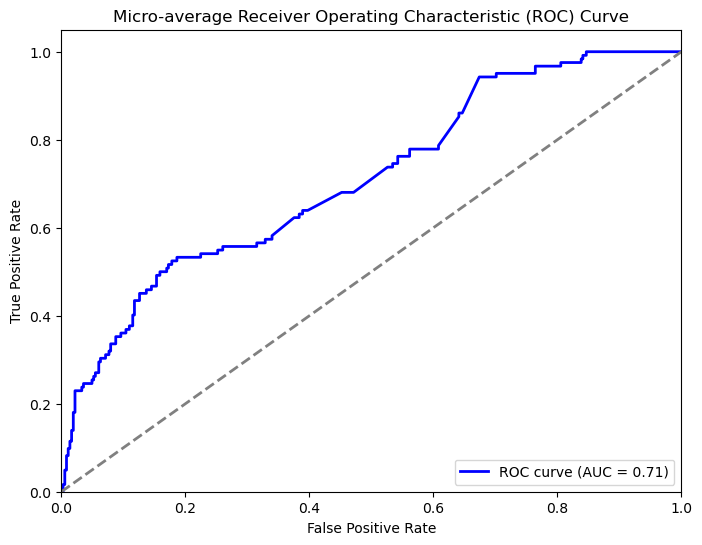

Mean Cross-Validated Accuracy: 0.8502419524510835
Standard Deviation of Accuracy: 0.027946521340208013
Mean AUC over folds: 0.8899726027397261
Standard Deviation of AUC: 0.01165353164208672


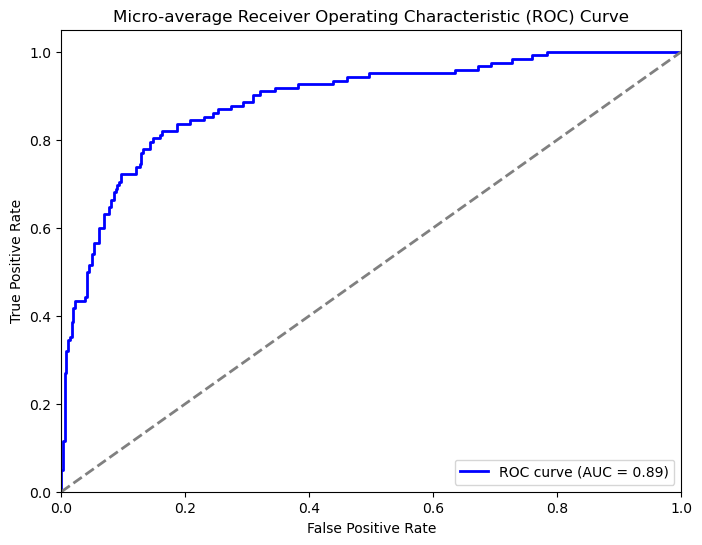

Mean Cross-Validated Accuracy: 0.8235219861140333
Standard Deviation of Accuracy: 0.030721591562168686
Mean AUC over folds: 0.8578584474885844
Standard Deviation of AUC: 0.020824763484147406


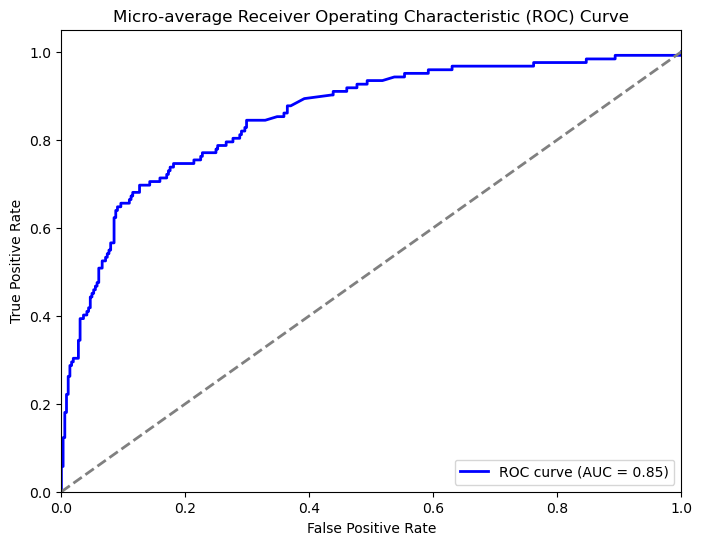

Mean Cross-Validated Accuracy: 0.8441195034714916
Standard Deviation of Accuracy: 0.042488140423128956
Mean AUC over folds: 0.9020730593607306
Standard Deviation of AUC: 0.03397607447768688


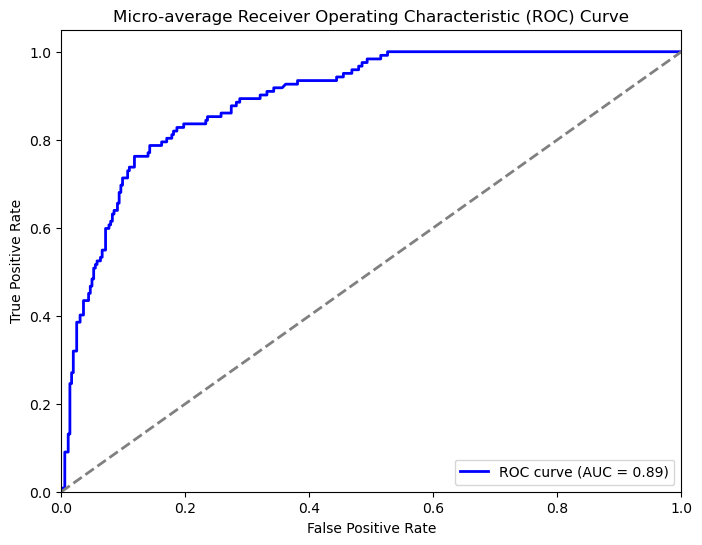

Mean Cross-Validated Accuracy: 0.8235009467704607
Standard Deviation of Accuracy: 0.04220223813995013
Mean AUC over folds: 0.7968744292237443
Standard Deviation of AUC: 0.06635947961055774


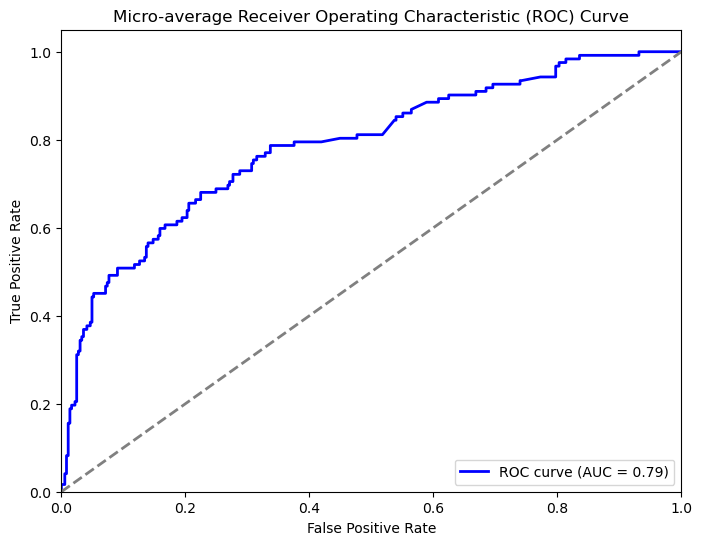

Mean Cross-Validated Accuracy: 0.7495055754260467
Standard Deviation of Accuracy: 0.0037621029081247766
Mean AUC over folds: 0.5847808219178081
Standard Deviation of AUC: 0.054896107505099476


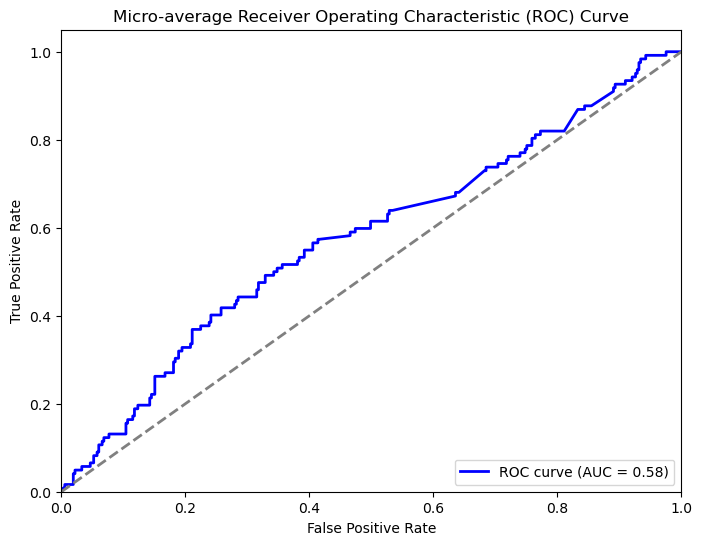

Mean Cross-Validated Accuracy: 0.7804544498211655
Standard Deviation of Accuracy: 0.03539027725917368
Mean AUC over folds: 0.7668561643835616
Standard Deviation of AUC: 0.06824424316262093


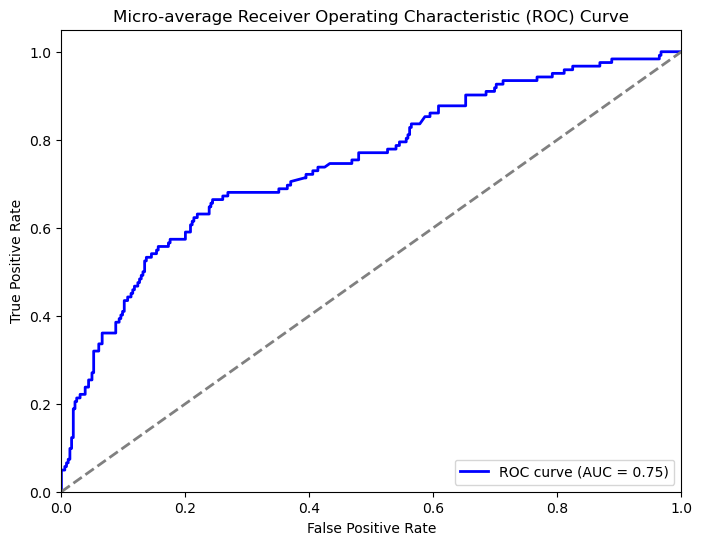

Mean Cross-Validated Accuracy: 0.7474647590995162
Standard Deviation of Accuracy: 0.007044128073331879
Mean AUC over folds: 0.6576529680365297
Standard Deviation of AUC: 0.10294036967955858


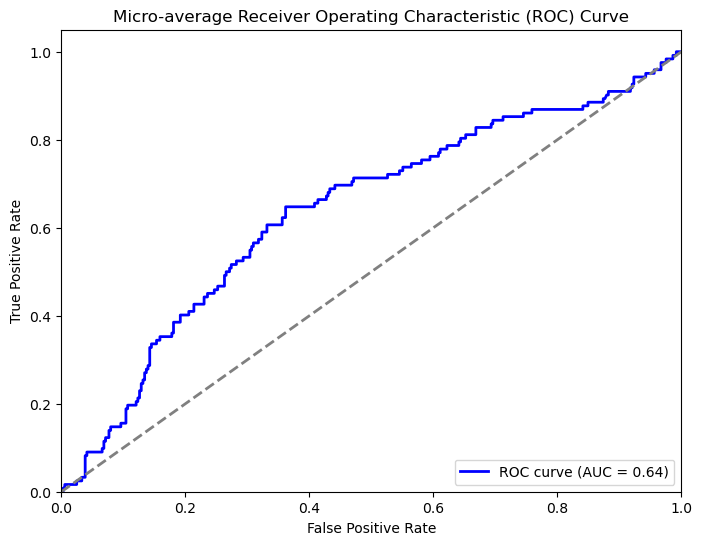

Mean Cross-Validated Accuracy: 0.8030086261308647
Standard Deviation of Accuracy: 0.03188301319719589
Mean AUC over folds: 0.8401780821917809
Standard Deviation of AUC: 0.09573608194080023


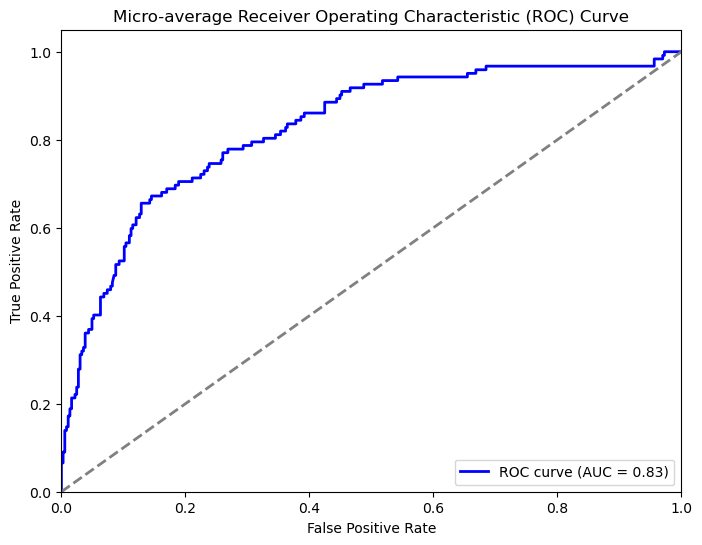

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict

# Create an empty dictionary to store SVM classifiers and their predictions
SVM_Classifier = {}

# Loop through the DataFrames in the 'log_targets' dictionary
for dataframe_name, log_target_df in log_targets.items():
    # Assuming 'labels' is a DataFrame containing labels as "label" column
   
    
    # Create and train the SVM classifier using your custom function
    svm_classifier = SVM(log_target_df,labels["label"])
    
    
    # Store the classifier and predictions in the 'SVM_Classifier' dictionary
    SVM_Classifier[dataframe_name] = {
        'classifier': svm_classifier  
    }
    #print(log_target_df)

In [5]:
import pickle

# Specify the filename for the pickle file
output_filename = 'SVM_Classifier.pkl'

# Save the 'SVM_Classifier' dictionary to the pickle file
with open(output_filename, 'wb') as file:
    pickle.dump(SVM_Classifier, file)

# Now, 'SVM_Classifier' is saved to 'SVM_Classifier.pkl'


In [6]:
import pickle

# Specify the filename for the pickle file
output_filename = 'SVM_Classifier_Components.pkl'

# Create dictionaries to store each component separately
fpr_dict = {}
tpr_dict = {}
auc_dict = {}
mean_acc_dict = {}
std_acc_dict = {}

# Loop through the classifiers in the 'SVM_Classifier' dictionary
for dataframe_name, classifier_info in SVM_Classifier.items():
    classifier = classifier_info['classifier']
    
    # Get the components of the classifier
    fpr = classifier[1]
    tpr = classifier[2]
    auc = classifier[3]
    mean_acc = classifier[4]
    std_acc = classifier[5]
    
    # Store each component in its respective dictionary
    fpr_dict[dataframe_name] = fpr
    tpr_dict[dataframe_name] = tpr
    auc_dict[dataframe_name] = auc
    mean_acc_dict[dataframe_name] = mean_acc
    std_acc_dict[dataframe_name] = std_acc

# Create a dictionary to store all component dictionaries
classifier_components = {
    'fpr': fpr_dict,
    'tpr': tpr_dict,
    'auc': auc_dict,
    'mean_acc': mean_acc_dict,
    'std_acc': std_acc_dict
}

# Save the component dictionaries to the pickle file
with open(output_filename, 'wb') as file:
    pickle.dump(classifier_components, file)

# Now, 'classifier_components' is saved to 'SVM_Classifier_Components.pkl'


Mean Cross-Validated Accuracy: 0.8851041447506838
Standard Deviation of Accuracy: 0.029716938884209867
Mean AUC over folds: 0.931689497716895
Standard Deviation of AUC: 0.027940489648951218


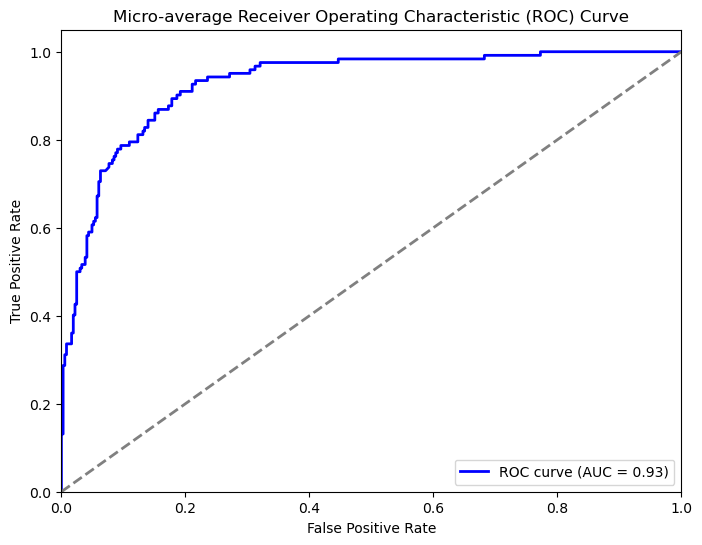

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
# Concatenate all DataFrames in the 'log_targets' dictionary
concatenated_df = pd.concat(log_targets.values(), axis=1)
svm_classifier = SVM(concatenated_df,labels["label"])
fpr1 = svm_classifier[1]
tpr1 = svm_classifier[2]
auc1 = svm_classifier[3]
mean_acc1 = svm_classifier[4]
std_acc1 = svm_classifier[5]


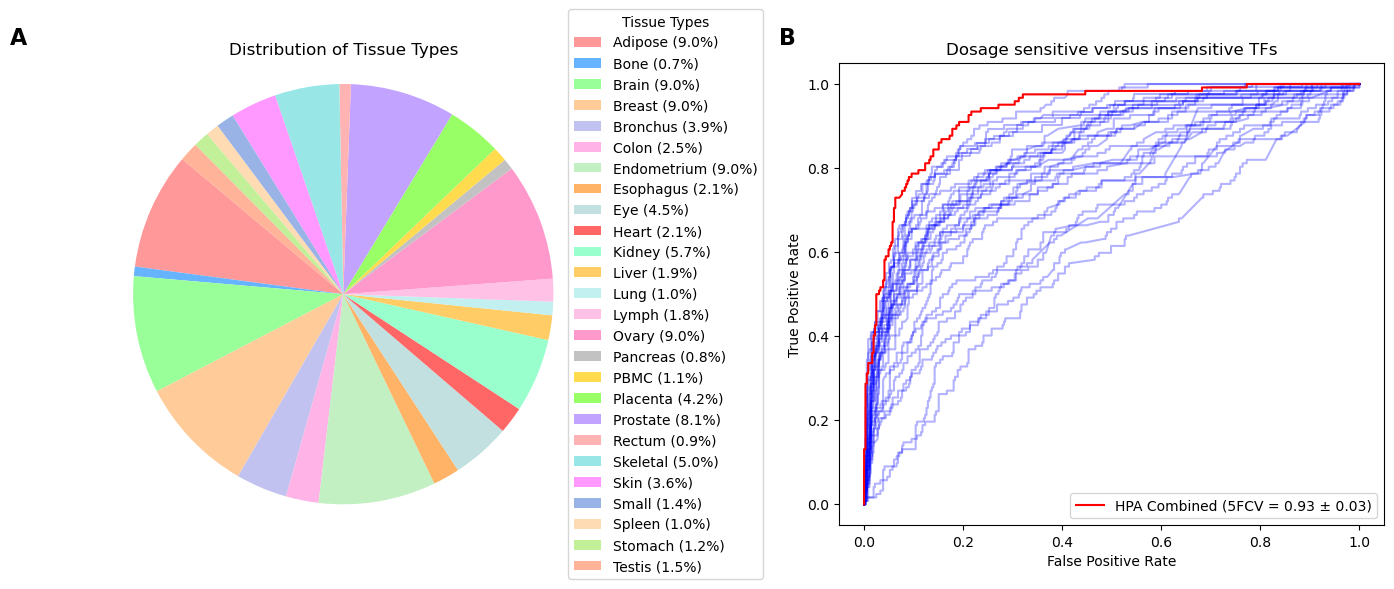

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Data for the pie chart
labels = [
    'Adipose', 'Bone', 'Brain', 'Breast', 'Bronchus', 'Colon', 'Endometrium',
    'Esophagus', 'Eye', 'Heart', 'Kidney', 'Liver', 'Lung', 'Lymph', 'Ovary',
    'Pancreas', 'PBMC', 'Placenta', 'Prostate', 'Rectum', 'Skeletal', 'Skin',
    'Small', 'Spleen', 'Stomach', 'Testis'
]
sizes = [
    40000, 3230, 40000, 40000, 17520, 11167, 40000, 9117, 20090, 9182,
    25279, 8439, 4599, 7771, 40000, 3719, 4972, 18547, 35862, 3898, 22030, 15798,
    6167, 4512, 5318, 6490
]

# Define custom colors for the pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2',
          '#ffb366', '#c2e0e0', '#ff6666', '#99ffcc', '#ffcc66', '#c2f0f0', '#ffc2e6',
          '#ff99cc', '#c2c2c2', '#ffdb4d', '#99ff66', '#c2a3ff', '#ffb3b3', '#99e6e6',
          '#ff99ff', '#99b3e6', '#ffdbb3', '#c2f099', '#ffb399', '#b3ffb3']

# Plot the pie chart on the left (axs[0])
axs[0].pie(sizes, labels=None, autopct='', startangle=140, colors=colors)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].legend(labels=[f'{label} ({size/sum(sizes)*100:.1f}%)' for label, size in zip(labels, sizes)],
           title="Tissue Types", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))
axs[0].set_title('Distribution of Tissue Types')

# Plot the ROC curve plot on the right (axs[1])
# Define a color with reduced opacity (alpha)
color = 'blue'
alpha = 0.3  # Adjust the alpha value as needed (0.0 to 1.0)

# Loop through the classifiers in the 'classifier_components' dictionary
for dataframe_name, components in classifier_components['fpr'].items():
    fpr = components
    tpr = classifier_components['tpr'][dataframe_name]

    # Plot the ROC curve with reduced opacity and without a label
    axs[1].plot(fpr, tpr, color=color, alpha=alpha)

# Calculate the mean and standard deviation of mean_acc and std_acc
mean_acc = np.mean([classifier_components['mean_acc'][key] for key in classifier_components['mean_acc']])
std_acc = np.std([classifier_components['std_acc'][key] for key in classifier_components['std_acc']])

# Plot the combined ROC curve with mean_acc and std_acc and add a legend for it
axs[1].plot(fpr1, tpr1, label='HPA Combined (5FCV = %0.2f ± %0.2f)' % (mean_acc1, std_acc1), color="red")
axs[1].set_title('Dosage sensitive versus insensitive TFs')

# Set axis labels
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')

# Add labels to the top of the individual subplots
axs[0].text(-0.08, 1.08, 'A', transform=axs[0].transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].text(-0.08, 1.08, 'B', transform=axs[1].transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].legend()
# Save the figure as "Figure2.png"
plt.savefig('Figure2.png', dpi=300)  # You can specify the file format and DPI as needed

# Display the plot
plt.tight_layout()  # Ensures that subplots do not overlap
plt.show()


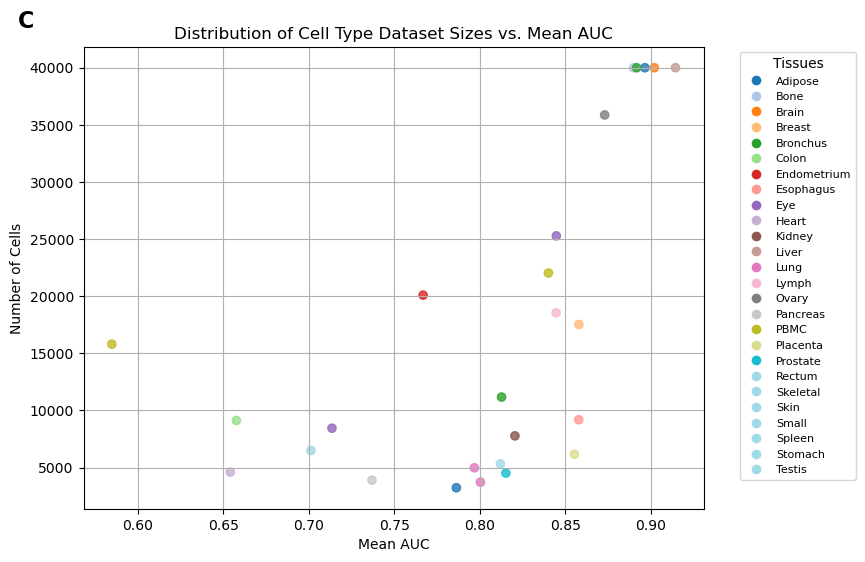

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the scatter plot
labels = [
    'Adipose', 'Bone', 'Brain', 'Breast', 'Bronchus', 'Colon', 'Endometrium',
    'Esophagus', 'Eye', 'Heart', 'Kidney', 'Liver', 'Lung', 'Lymph', 'Ovary',
    'Pancreas', 'PBMC', 'Placenta', 'Prostate', 'Rectum', 'Skeletal', 'Skin',
    'Small', 'Spleen', 'Stomach', 'Testis'
]
sizes = [
    40000, 3230, 40000, 40000, 17520, 11167, 40000, 9117, 20090, 9182,
    25279, 8439, 4599, 7771, 40000, 3719, 4972, 18547, 35862, 3898, 22030, 15798,
    6167, 4512, 5318, 6490
]
mean_acc_values = [0.8965753424657533, 0.7863150684931506, 0.8899726027397261, 0.9020730593607306, 0.858027397260274, 0.8127511415525115, 0.8917625570776255,
                  0.6576529680365297, 0.7668561643835616, 0.8578584474885844, 0.844796803652968, 0.7135388127853881, 0.6540525114155251, 0.8205639269406394, 0.9144794520547945,
                   0.8003972602739726, 0.7968744292237443, 0.8446712328767123, 0.8730662100456621, 0.7369155251141553, 0.8401780821917809, 0.5847808219178081,
                   0.855351598173516, 0.8152694063926941, 0.8120525114155251, 0.7012602739726027
                  ]  # Replace with your actual mean_acc values

# Create a subplot
fig, axs = plt.subplots(figsize=(8, 6))

# Create a scatter plot with different colors for each dot
scatter = axs.scatter(mean_acc_values, sizes, c=range(len(labels)), cmap='tab20', alpha=0.8)

# Set axis labels and title
axs.set_xlabel('Mean AUC')
axs.set_ylabel('Number of Cells')
axs.set_title('Distribution of Cell Type Dataset Sizes vs. Mean AUC')

# Add labels to the legend one by one
legend_handles = []
for i, label in enumerate(labels):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=8, label=f'{label}'))

# Create the legend
axs.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1), title='Tissues', fontsize=8)

# Add label at the top
axs.text(-0.08, 1.08, 'C', transform=axs.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Display the plot
plt.grid(True)
plt.show()


### Figure 3

Explained Variance Ratio:
PC1: 0.0739
PC2: 0.0425
Explained Variance Ratio:
PC1: 0.7582
PC2: 0.0324
Explained Variance Ratio:
PC1: 0.7600
PC2: 0.0272
Explained Variance Ratio:
PC1: 0.5135
PC2: 0.0381


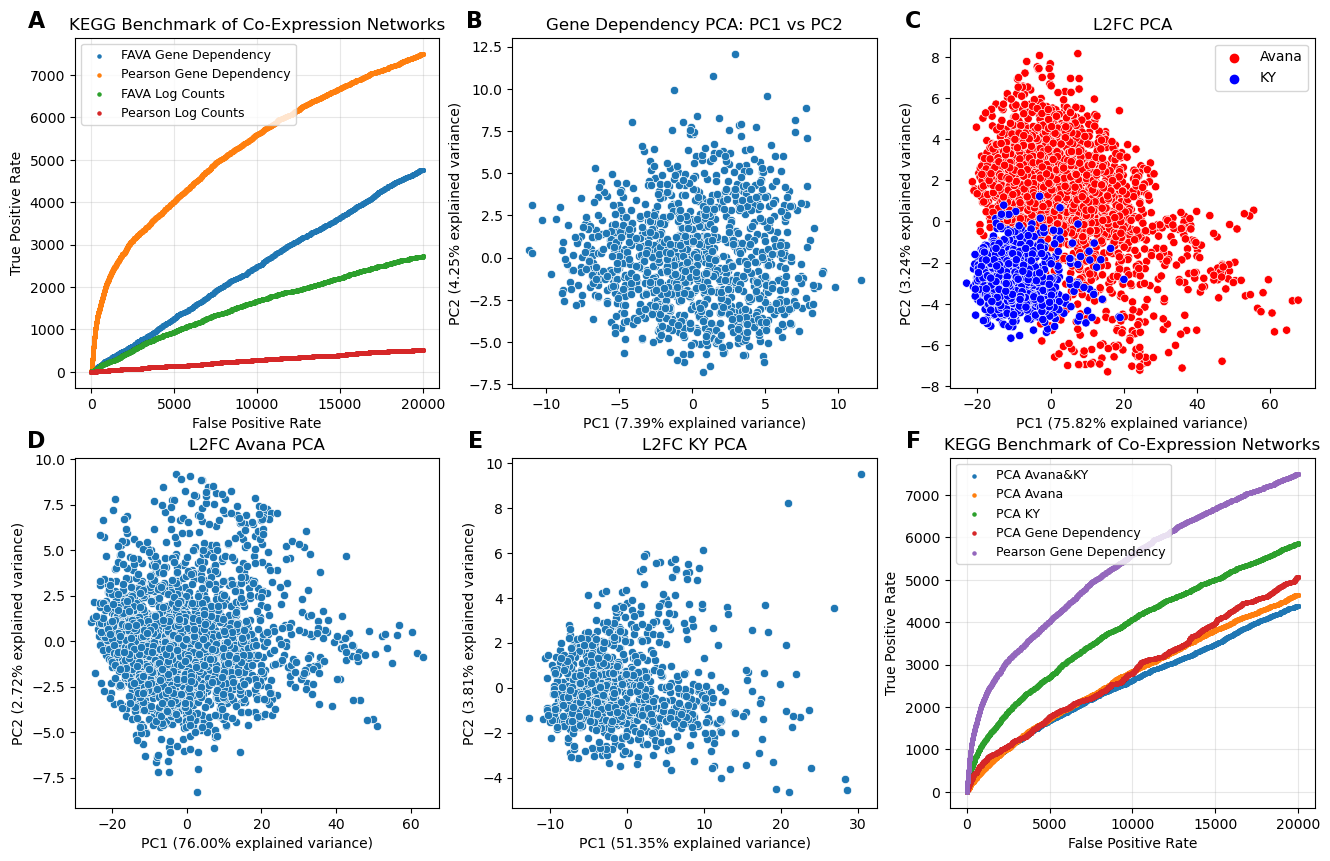

In [13]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

# Load and preprocess your data (assuming the data is correctly formatted)
input_file = 'CRISPR_Image_Stuff/KEGG_Benchmarked_GeneDependency_1000H_100L_Network.tsv'
input_file2 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_GeneDependency_1000H_100L_Network.tsv'
input_file3 = 'CRISPR_Image_Stuff/KEGG_Benchmarked_GeneLog_1000H_100L_Network.tsv'
input_file4 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_GeneLog_1000H_100L_Network.tsv'

df11 = pd.read_csv(input_file, sep="\t")
df1 = df11[df11['fp_cum'] <= 20000]

df22 = pd.read_csv(input_file2, sep="\t")
df2 = df22[df22['fp_cum'] <= 20000]

df33 = pd.read_csv(input_file3, sep="\t")
df3 = df33[df33['fp_cum'] <= 20000]

df44 = pd.read_csv(input_file4, sep="\t")
df4 = df44[df44['fp_cum'] <= 20000]

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Scatter plot in the top-left subplot (axs[0, 0])
axs[0, 0].grid(True)  # Enable grid lines
axs[0, 0].scatter(df1['fp_cum'], df1['tp_cum'], label='FAVA Gene Dependency', s=5, zorder=2)
axs[0, 0].scatter(df2['fp_cum'], df2['tp_cum'], label='Pearson Gene Dependency', s=5, zorder=2)
axs[0, 0].scatter(df3['fp_cum'], df3['tp_cum'], label='FAVA Log Counts', s=5, zorder=2)
axs[0, 0].scatter(df4['fp_cum'], df4['tp_cum'], label='Pearson Log Counts', s=5, zorder=2)

# Adding legend and adjusting its properties
legend = axs[0, 0].legend(loc='upper left', fontsize=9)
axs[0, 0].set_title("KEGG Benchmark of Co-Expression Networks")  # Use set_title for the title
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].grid(True, alpha=0.3)  # Enable grid lines

# Now, let's perform PCA on the data and plot it in the top-right subplot (axs[0, 1])
df = pd.read_csv('CRISPR_Image_Stuff/CRISPRGeneDependency_CorrelationMatrix.csv', sep='\t', index_col=0)
df = df.fillna(0)
df = df.transpose()

# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 2 principal components
explained_variance_ratio = pca.explained_variance_ratio_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

scatter = sns.scatterplot(x=pc1, y=pc2, ax=axs[0, 1])
axs[0, 1].set_xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
axs[0, 1].set_ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
axs[0, 1].set_title("Gene Dependency PCA: PC1 vs PC2")

df = pd.read_csv('CRISPR_Image_Stuff//GeneL2FC_Avana_KY.tsv', sep='\t', index_col=0)
df = df.transpose()
# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'

df.iloc[:, :2077] = 'Avana'  # Update labels for the first 2077 columns
df.iloc[2077:, :] = 'KY'


scatter = sns.scatterplot(x=pc1, y=pc2, ax=axs[0, 2], hue=df.iloc[:,0], palette={"Avana": "red", "KY": "blue"})
axs[0, 2].set_xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
axs[0, 2].set_ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
axs[0, 2].set_title("L2FC PCA")

# Remove the legend title
legend = scatter.legend()

df = pd.read_csv('CRISPR_Image_Stuff//AvanaLogFoldchange_CorrelationMatrix.txt', sep='\t', index_col=0)
df = df.fillna(0) 
mask = df.isna()

df = df.fillna(df.mean())

    
for col in df:
    Scaled = df[col].values
    
    
    Scaled -= Scaled.min()  # equivalent to df = df - df.min()
    Scaled /= Scaled.max()  

    # replace the original column with the scaled values
    df[col] = Scaled
    

df = df.mask(mask)
df = df.transpose()
# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'


scatter = sns.scatterplot(x=pc1, y=pc2, ax=axs[1, 0])
axs[1, 0].set_xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
axs[1, 0].set_ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
axs[1, 0].set_title("L2FC Avana PCA")

df = pd.read_csv('CRISPR_Image_Stuff//KYLogFoldchange_CorrelationMatrix.txt', sep='\t', index_col=0)
df = df.fillna(0) 
mask = df.isna()

df = df.fillna(df.mean())

    
for col in df:
    Scaled = df[col].values
    
    
    Scaled -= Scaled.min()  # equivalent to df = df - df.min()
    Scaled /= Scaled.max()  

    # replace the original column with the scaled values
    df[col] = Scaled
    

df = df.mask(mask)
df = df.transpose()
# Perform PCA on the imputed DataFrame
pca = PCA(n_components=2)
pca.fit(df)

# Extract information about the first 10 principal components
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_

# Print explained variance ratio
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {ratio:.4f}")

# Plot PC1 and PC2 with coloration based on labels
pc1 = pca.transform(df)[:, 0]
pc2 = pca.transform(df)[:, 1]

# Label the first 2077 columns as 'A' and the rest as 'B'


scatter = sns.scatterplot(x=pc1, y=pc2, ax=axs[1, 1])
axs[1, 1].set_xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} explained variance)")
axs[1, 1].set_ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} explained variance)")
axs[1, 1].set_title("L2FC KY PCA")



axs[0, 0].text(-0.08, 1.08, 'A', transform=axs[0, 0].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')

axs[0, 1].text(-0.08, 1.08, 'B', transform=axs[0, 1].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')

axs[0, 2].text(-0.08, 1.08, 'C', transform=axs[0, 2].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')

axs[1, 0].text(-0.08, 1.08, 'D', transform=axs[1, 0].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')

axs[1, 1].text(-0.08, 1.08, 'E', transform=axs[1, 1].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')

axs[1, 2].text(-0.08, 1.08, 'F', transform=axs[1, 2].transAxes,
               fontsize=16, fontweight='bold', va='top', ha='right')


# Load and preprocess your data (assuming the data is correctly formatted)
input_file = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_PCA_AvanaKY_Network.tsv'
input_file2 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_PCA_Avana_Network.tsv'
input_file3 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_PCA_KY_Network.tsv'
input_file4 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_PCA_GeneDep_Network.tsv'
input_file5 = 'CRISPR_Image_Stuff/Benchmarked_Kegg_Pearson_GeneDependency_1000H_100L_Network.tsv'

df11 = pd.read_csv(input_file, sep="\t")
df1 = df11[df11['fp_cum'] <= 20000]

df22 = pd.read_csv(input_file2, sep="\t")
df2 = df22[df22['fp_cum'] <= 20000]

df33 = pd.read_csv(input_file3, sep="\t")
df3 = df33[df33['fp_cum'] <= 20000]

df44 = pd.read_csv(input_file4, sep="\t")
df4 = df44[df44['fp_cum'] <= 20000]

df55 = pd.read_csv(input_file5, sep="\t")
df5 = df55[df55['fp_cum'] <= 20000]

# Scatter plot in the top-left subplot (axs[0, 0])
axs[1, 2].grid(True)  # Enable grid lines
axs[1, 2].scatter(df1['fp_cum'], df1['tp_cum'], label='PCA Avana&KY', s=5, zorder=2)
axs[1, 2].scatter(df2['fp_cum'], df2['tp_cum'], label='PCA Avana', s=5, zorder=2)
axs[1, 2].scatter(df3['fp_cum'], df3['tp_cum'], label='PCA KY', s=5, zorder=2)
axs[1, 2].scatter(df4['fp_cum'], df4['tp_cum'], label='PCA Gene Dependency', s=5, zorder=2)
axs[1, 2].scatter(df5['fp_cum'], df5['tp_cum'], label='Pearson Gene Dependency', s=5, zorder=2)

# Adding legend and adjusting its properties
legend = axs[1, 2].legend(loc='upper left', fontsize=9)
axs[1, 2].set_title("KEGG Benchmark of Co-Expression Networks")  # Use set_title for the title
axs[1, 2].set_xlabel("False Positive Rate")
axs[1, 2].set_ylabel("True Positive Rate")
axs[1, 2].grid(True, alpha=0.3)  # Enable grid lines

plt.savefig('Figure_2.png')
plt.show()
